In [19]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# Clasificadores
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

# Métricas y evaluación
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, 
                           precision_score, recall_score, f1_score, roc_auc_score,
                           roc_curve, precision_recall_curve, average_precision_score)

import pickle
import json
from tqdm import tqdm

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline

## 1. Carga de Datos y Configuración

In [20]:
# Cargar configuración del proyecto
with open(Path.cwd().parent / 'config.pkl', 'rb') as f:
    config = pickle.load(f)

PROJECT_ROOT = Path(config['PROJECT_ROOT'])
FEATURES_PATH = PROJECT_ROOT / 'data' / 'features'
RESULTS_PATH = PROJECT_ROOT / 'results'
MODELS_PATH = PROJECT_ROOT / 'models'

# Crear directorios
RESULTS_PATH.mkdir(parents=True, exist_ok=True)
MODELS_PATH.mkdir(parents=True, exist_ok=True)

RANDOM_SEED = config['RANDOM_SEED']
np.random.seed(RANDOM_SEED)

print(f"Proyecto: {PROJECT_ROOT}")
print(f"Características: {FEATURES_PATH}")
print(f"Modelos: {MODELS_PATH}")

Proyecto: c:\Users\juanm.sanchez\OneDrive - DISLICORES\Escritorio\Maestría\Semestre 2\Computer Vision\Trabajo 3\proyecto_clasificacion_neumonia
Características: c:\Users\juanm.sanchez\OneDrive - DISLICORES\Escritorio\Maestría\Semestre 2\Computer Vision\Trabajo 3\proyecto_clasificacion_neumonia\data\features
Modelos: c:\Users\juanm.sanchez\OneDrive - DISLICORES\Escritorio\Maestría\Semestre 2\Computer Vision\Trabajo 3\proyecto_clasificacion_neumonia\models


In [22]:
# Cargar características extraídas
def load_features():
    """Carga las características extraídas del dataset."""
    try:
        # Cargar metadatos
        with open(FEATURES_PATH / 'metadata.json', 'r') as f:
            metadata = json.load(f)
        
        data = {}
        for split in ['train', 'test', 'val']:
            features_path = FEATURES_PATH / f'{split}_features.npy'
            labels_path = FEATURES_PATH / f'{split}_labels.npy'
            
            if features_path.exists() and labels_path.exists():
                data[split] = {
                    'features': np.load(features_path),
                    'labels': np.load(labels_path)
                }
                print(f"{split.upper()}: {data[split]['features'].shape} features, {len(data[split]['labels'])} labels")
        
        return data, metadata
    except Exception as e:
        print(f"Error cargando características: {e}")
        return None, None

features_data, metadata = load_features()

TRAIN: (100, 26415) features, 100 labels
TEST: (100, 26415) features, 100 labels
VAL: (16, 26415) features, 16 labels


In [23]:
# Preparar datos para entrenamiento
if features_data:
    # Combinar train y val para entrenamiento (el dataset de validación es muy pequeño)
    if 'val' in features_data and len(features_data['val']['features']) > 0:
        X_train = np.vstack([features_data['train']['features'], features_data['val']['features']])
        y_train = np.hstack([features_data['train']['labels'], features_data['val']['labels']])
    else:
        X_train = features_data['train']['features']
        y_train = features_data['train']['labels']
    
    X_test = features_data['test']['features']
    y_test = features_data['test']['labels']
    
    print(f"Datos de entrenamiento: {X_train.shape}")
    print(f"Datos de prueba: {X_test.shape}")
    print(f"Distribución entrenamiento - Normal: {np.sum(y_train==0)}, Neumonía: {np.sum(y_train==1)}")
    print(f"Distribución prueba - Normal: {np.sum(y_test==0)}, Neumonía: {np.sum(y_test==1)}")
else:
    print("Error: No se pudieron cargar las características.")

Datos de entrenamiento: (116, 26415)
Datos de prueba: (100, 26415)
Distribución entrenamiento - Normal: 58, Neumonía: 58
Distribución prueba - Normal: 50, Neumonía: 50


## 2. Preprocesamiento y Selección de Características

In [24]:
def preprocess_features(X_train, X_test, method='standard'):
    """
    Preprocesa las características (normalización/estandarización).
    
    Args:
        X_train: Características de entrenamiento
        X_test: Características de prueba
        method: 'standard', 'minmax', o 'none'
    
    Returns:
        X_train_scaled, X_test_scaled, scaler
    """
    if method == 'standard':
        scaler = StandardScaler()
    elif method == 'minmax':
        scaler = MinMaxScaler()
    else:
        return X_train, X_test, None
    
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, scaler

def select_features(X_train, y_train, X_test, method='selectk', k=100):
    """
    Selecciona las mejores características.
    
    Args:
        X_train: Características de entrenamiento
        y_train: Etiquetas de entrenamiento
        X_test: Características de prueba
        method: 'selectk', 'pca', 'rfe'
        k: Número de características a seleccionar
    
    Returns:
        X_train_selected, X_test_selected, selector
    """
    if method == 'selectk':
        selector = SelectKBest(score_func=f_classif, k=k)
    elif method == 'pca':
        selector = PCA(n_components=k)
    elif method == 'rfe':
        estimator = RandomForestClassifier(n_estimators=50, random_state=RANDOM_SEED)
        selector = RFE(estimator=estimator, n_features_to_select=k)
    else:
        return X_train, X_test, None
    
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)
    
    return X_train_selected, X_test_selected, selector

# Aplicar preprocesamiento
if features_data:
    print("Aplicando preprocesamiento...")
    
    # Estandarización
    X_train_scaled, X_test_scaled, scaler = preprocess_features(X_train, X_test, method='standard')
    
    # Selección de características (usar las mejores 200)
    n_features = min(200, X_train_scaled.shape[1])
    X_train_final, X_test_final, feature_selector = select_features(
        X_train_scaled, y_train, X_test_scaled, method='selectk', k=n_features
    )
    
    print(f"Características originales: {X_train.shape[1]}")
    print(f"Características seleccionadas: {X_train_final.shape[1]}")
    
    # Verificar que no hay valores NaN o infinitos
    print(f"NaN en entrenamiento: {np.isnan(X_train_final).sum()}")
    print(f"Inf en entrenamiento: {np.isinf(X_train_final).sum()}")

Aplicando preprocesamiento...
Características originales: 26415
Características seleccionadas: 200
NaN en entrenamiento: 0
Inf en entrenamiento: 0


## 3. Definición de Clasificadores

In [25]:
# Definir clasificadores y sus hiperparámetros
def get_classifiers():
    """Retorna un diccionario con los clasificadores y sus parámetros para Grid Search."""
    
    classifiers = {
        'Logistic Regression': {
            'classifier': LogisticRegression(random_state=RANDOM_SEED, max_iter=1000),
            'params': {
                'C': [0.01, 0.1, 1, 10, 100],
                'penalty': ['l1', 'l2'],
                'solver': ['liblinear']
            }
        },
        
        'SVM': {
            'classifier': SVC(random_state=RANDOM_SEED, probability=True),
            'params': {
                'C': [0.1, 1, 10, 100],
                'kernel': ['linear', 'rbf', 'poly'],
                'gamma': ['scale', 'auto']
            }
        },
        
        'Random Forest': {
            'classifier': RandomForestClassifier(random_state=RANDOM_SEED),
            'params': {
                'n_estimators': [50, 100, 200],
                'max_depth': [10, 20, None],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4]
            }
        },
        
        'Gradient Boosting': {
            'classifier': GradientBoostingClassifier(random_state=RANDOM_SEED),
            'params': {
                'n_estimators': [50, 100, 200],
                'learning_rate': [0.01, 0.1, 0.2],
                'max_depth': [3, 5, 7]
            }
        },
        
        'k-NN': {
            'classifier': KNeighborsClassifier(),
            'params': {
                'n_neighbors': [3, 5, 7, 9, 11],
                'weights': ['uniform', 'distance'],
                'metric': ['euclidean', 'manhattan', 'minkowski']
            }
        },
        
        'Naive Bayes': {
            'classifier': GaussianNB(),
            'params': {
                'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]
            }
        }
    }
    
    return classifiers

classifiers = get_classifiers()
print("Clasificadores definidos:")
for name in classifiers.keys():
    print(f"  - {name}")

Clasificadores definidos:
  - Logistic Regression
  - SVM
  - Random Forest
  - Gradient Boosting
  - k-NN
  - Naive Bayes


## 4. Entrenamiento y Optimización de Hiperparámetros

In [26]:
def train_and_optimize_classifier(name, classifier_info, X_train, y_train, cv_folds=5):
    """
    Entrena y optimiza un clasificador usando Grid Search.
    
    Args:
        name: Nombre del clasificador
        classifier_info: Diccionario con 'classifier' y 'params'
        X_train: Características de entrenamiento
        y_train: Etiquetas de entrenamiento
        cv_folds: Número de folds para validación cruzada
    
    Returns:
        best_classifier, best_params, cv_scores
    """
    print(f"\nEntrenando {name}...")
    
    # Configurar validación cruzada estratificada
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=RANDOM_SEED)
    
    # Grid Search
    grid_search = GridSearchCV(
        classifier_info['classifier'],
        classifier_info['params'],
        cv=cv,
        scoring='f1',  # Usar F1-score como métrica principal
        n_jobs=-1,  # Usar todos los cores disponibles
        verbose=1
    )
    
    # Entrenar
    grid_search.fit(X_train, y_train)
    
    # Obtener mejores resultados
    best_classifier = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    
    print(f"Mejores parámetros para {name}: {best_params}")
    print(f"Mejor F1-score CV: {best_score:.4f}")
    
    return best_classifier, best_params, best_score

# Entrenar todos los clasificadores
if features_data:
    trained_models = {}
    training_results = {}
    
    for name, classifier_info in classifiers.items():
        try:
            best_model, best_params, cv_score = train_and_optimize_classifier(
                name, classifier_info, X_train_final, y_train, cv_folds=5
            )
            
            trained_models[name] = best_model
            training_results[name] = {
                'best_params': best_params,
                'cv_f1_score': cv_score
            }
            
        except Exception as e:
            print(f"Error entrenando {name}: {e}")
            continue
    
    print(f"\nModelos entrenados exitosamente: {len(trained_models)}")


Entrenando Logistic Regression...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Mejores parámetros para Logistic Regression: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
Mejor F1-score CV: 0.9513

Entrenando SVM...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Mejores parámetros para SVM: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Mejor F1-score CV: 0.9513

Entrenando Random Forest...
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Mejores parámetros para Random Forest: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Mejor F1-score CV: 0.9139

Entrenando Gradient Boosting...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Mejores parámetros para Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
Mejor F1-score CV: 0.8325

Entrenando k-NN...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Mejores parámetros para k-NN: {'metric': 'euclidean', 

## 5. Evaluación en Conjunto de Prueba

In [27]:
def evaluate_classifier(model, X_test, y_test, model_name):
    """
    Evalúa un clasificador en el conjunto de prueba.
    
    Args:
        model: Clasificador entrenado
        X_test: Características de prueba
        y_test: Etiquetas verdaderas de prueba
        model_name: Nombre del modelo
    
    Returns:
        dict: Diccionario con todas las métricas
    """
    # Predicciones
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # Métricas básicas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # AUC-ROC (solo si hay probabilidades)
    auc_roc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
    
    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    
    # Reporte de clasificación
    class_report = classification_report(y_test, y_pred, target_names=['Normal', 'Pneumonia'], output_dict=True)
    
    return {
        'model_name': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc_roc': auc_roc,
        'confusion_matrix': cm,
        'classification_report': class_report,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }

# Evaluar todos los modelos
if trained_models:
    evaluation_results = {}
    
    print("Evaluando modelos en conjunto de prueba...\n")
    
    for name, model in trained_models.items():
        results = evaluate_classifier(model, X_test_final, y_test, name)
        evaluation_results[name] = results
        
        print(f"=== {name} ===")
        print(f"Accuracy: {results['accuracy']:.4f}")
        print(f"Precision: {results['precision']:.4f}")
        print(f"Recall: {results['recall']:.4f}")
        print(f"F1-Score: {results['f1_score']:.4f}")
        if results['auc_roc'] is not None:
            print(f"AUC-ROC: {results['auc_roc']:.4f}")
        print()

Evaluando modelos en conjunto de prueba...

=== Logistic Regression ===
Accuracy: 0.6400
Precision: 0.5875
Recall: 0.9400
F1-Score: 0.7231
AUC-ROC: 0.8772

=== SVM ===
Accuracy: 0.6600
Precision: 0.6026
Recall: 0.9400
F1-Score: 0.7344
AUC-ROC: 0.8864

=== Random Forest ===
Accuracy: 0.7300
Precision: 0.6769
Recall: 0.8800
F1-Score: 0.7652
AUC-ROC: 0.8626

=== Gradient Boosting ===
Accuracy: 0.5900
Precision: 0.5542
Recall: 0.9200
F1-Score: 0.6917
AUC-ROC: 0.7040

=== k-NN ===
Accuracy: 0.7900
Precision: 0.7458
Recall: 0.8800
F1-Score: 0.8073
AUC-ROC: 0.8726

=== Naive Bayes ===
Accuracy: 0.7000
Precision: 0.6429
Recall: 0.9000
F1-Score: 0.7500
AUC-ROC: 0.7674



## 6. Visualización de Resultados

Generando visualizaciones...


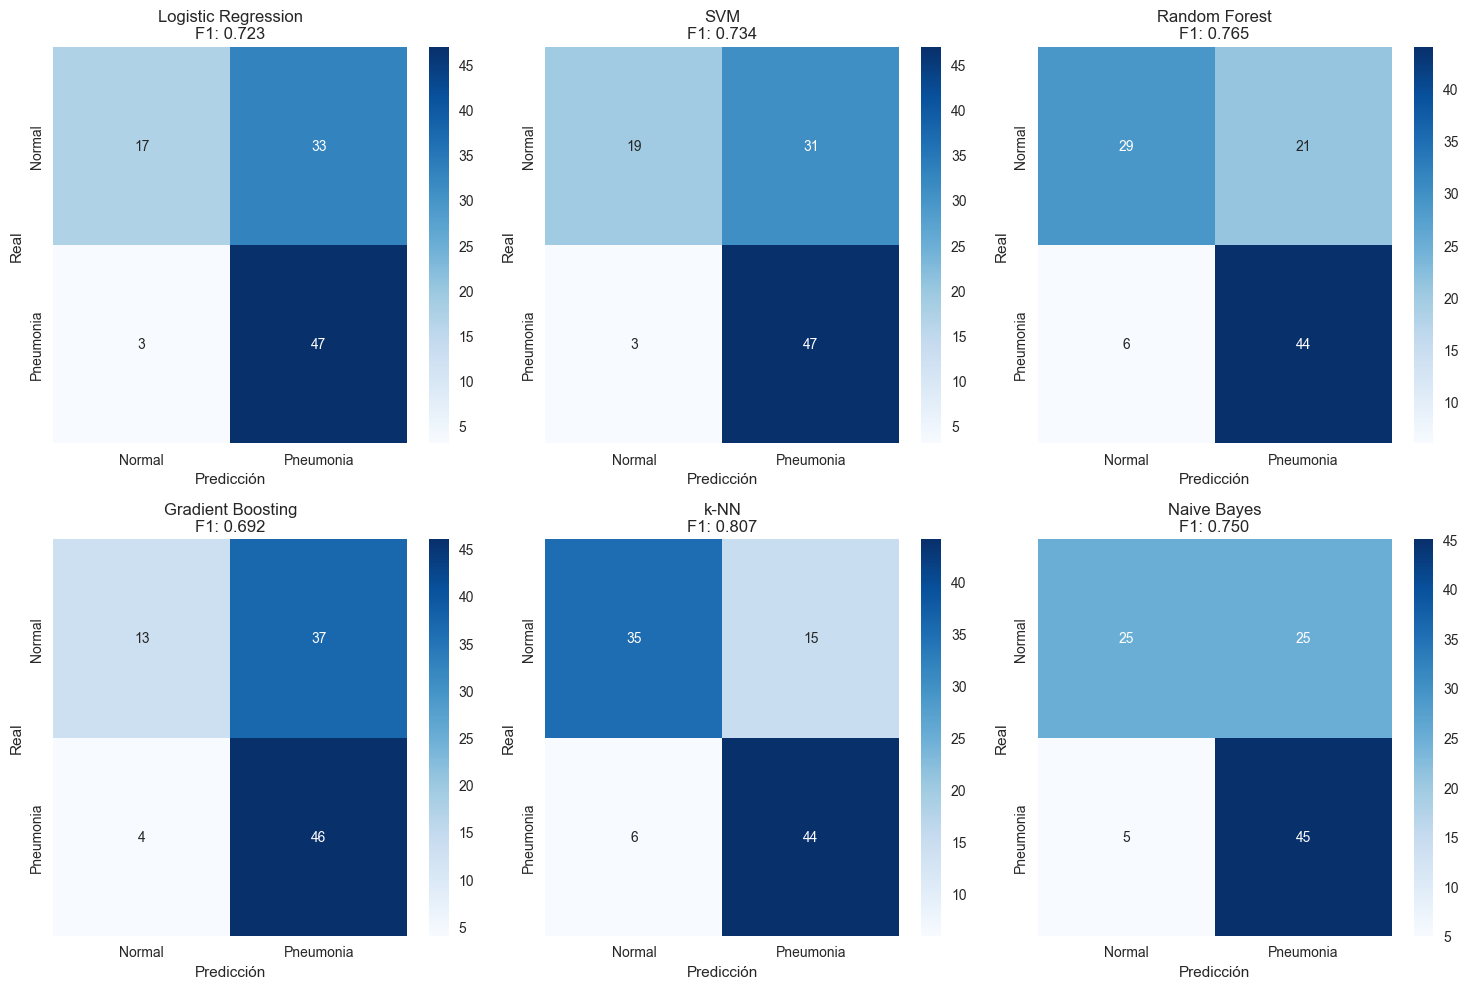

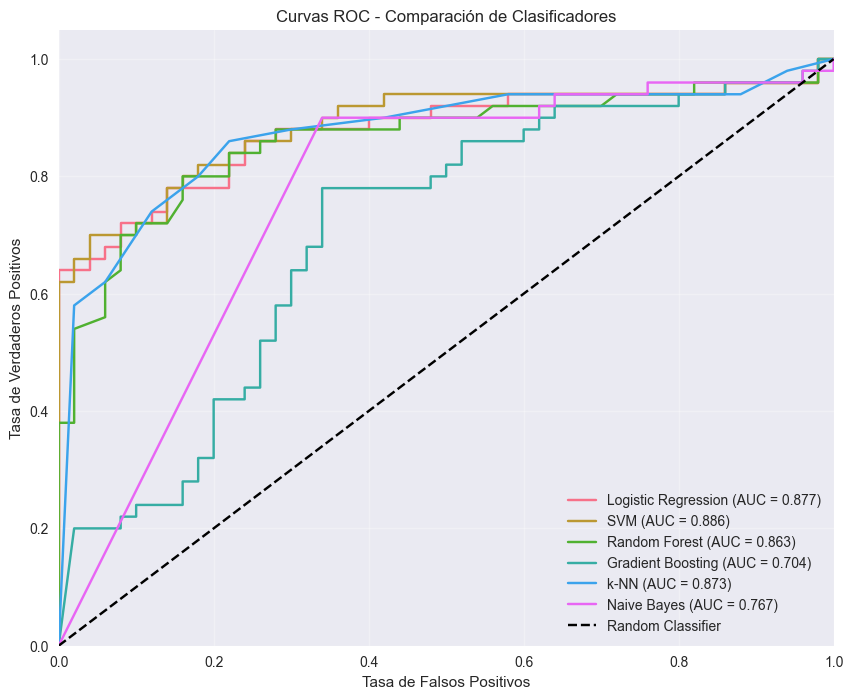

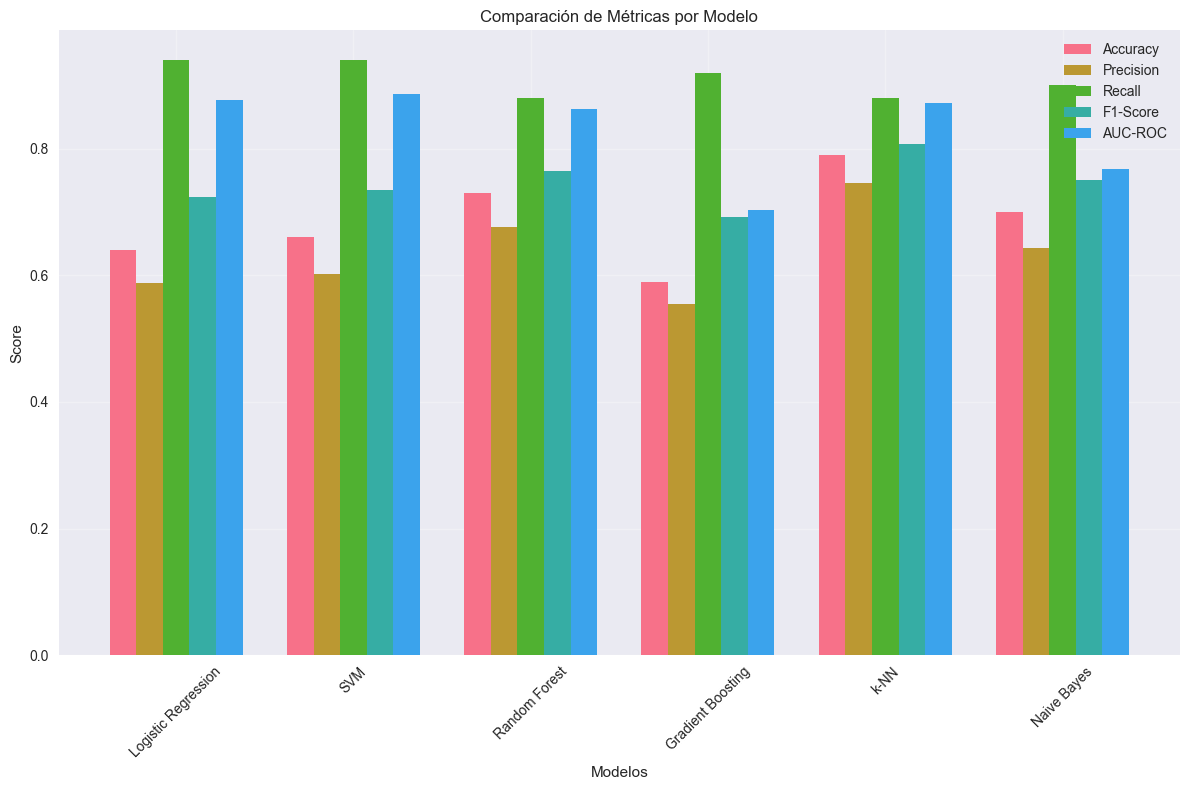


Tabla de Resultados:


,Model,Accuracy,Precision,Recall,F1-Score,AUC-ROC
0,Logistic Regression,0.64,0.5875,0.94,0.7231,0.8772
1,SVM,0.66,0.6026,0.94,0.7344,0.8864
2,Random Forest,0.73,0.6769,0.88,0.7652,0.8626
3,Gradient Boosting,0.59,0.5542,0.92,0.6917,0.7040
4,k-NN,0.79,0.7458,0.88,0.8073,0.8726
5,Naive Bayes,0.70,0.6429,0.90,0.7500,0.7674


In [28]:
def plot_confusion_matrices(evaluation_results, figsize=(15, 10)):
    """Plotea las matrices de confusión de todos los modelos."""
    n_models = len(evaluation_results)
    cols = 3
    rows = (n_models + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten() if n_models > 1 else [axes]
    
    for idx, (name, results) in enumerate(evaluation_results.items()):
        cm = results['confusion_matrix']
        
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=['Normal', 'Pneumonia'],
                   yticklabels=['Normal', 'Pneumonia'],
                   ax=axes[idx])
        
        axes[idx].set_title(f'{name}\nF1: {results["f1_score"]:.3f}')
        axes[idx].set_xlabel('Predicción')
        axes[idx].set_ylabel('Real')
    
    # Ocultar ejes sobrantes
    for idx in range(n_models, len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.savefig(RESULTS_PATH / 'confusion_matrices.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_roc_curves(evaluation_results):
    """Plotea las curvas ROC de todos los modelos."""
    plt.figure(figsize=(10, 8))
    
    for name, results in evaluation_results.items():
        if results['y_pred_proba'] is not None:
            fpr, tpr, _ = roc_curve(y_test, results['y_pred_proba'])
            auc = results['auc_roc']
            plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.title('Curvas ROC - Comparación de Clasificadores')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.savefig(RESULTS_PATH / 'roc_curves.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_metrics_comparison(evaluation_results):
    """Plotea una comparación de métricas entre modelos."""
    metrics_data = []
    
    for name, results in evaluation_results.items():
        metrics_data.append({
            'Model': name,
            'Accuracy': results['accuracy'],
            'Precision': results['precision'],
            'Recall': results['recall'],
            'F1-Score': results['f1_score'],
            'AUC-ROC': results['auc_roc'] if results['auc_roc'] is not None else 0
        })
    
    df_metrics = pd.DataFrame(metrics_data)
    
    # Gráfico de barras
    fig, ax = plt.subplots(figsize=(12, 8))
    
    metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']
    x = np.arange(len(df_metrics))
    width = 0.15
    
    for i, metric in enumerate(metrics_to_plot):
        ax.bar(x + i * width, df_metrics[metric], width, label=metric)
    
    ax.set_xlabel('Modelos')
    ax.set_ylabel('Score')
    ax.set_title('Comparación de Métricas por Modelo')
    ax.set_xticks(x + width * 2)
    ax.set_xticklabels(df_metrics['Model'], rotation=45)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(RESULTS_PATH / 'metrics_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return df_metrics

# Generar visualizaciones
if evaluation_results:
    print("Generando visualizaciones...")
    
    # Matrices de confusión
    plot_confusion_matrices(evaluation_results)
    
    # Curvas ROC
    plot_roc_curves(evaluation_results)
    
    # Comparación de métricas
    df_metrics = plot_metrics_comparison(evaluation_results)
    
    # Mostrar tabla de resultados
    print("\nTabla de Resultados:")
    display(df_metrics.round(4))

## 7. Análisis de Resultados y Ranking de Modelos

In [29]:
def create_results_summary(evaluation_results, training_results):
    """Crea un resumen completo de los resultados."""
    
    summary_data = []
    
    for name in evaluation_results.keys():
        eval_res = evaluation_results[name]
        train_res = training_results[name]
        
        summary_data.append({
            'Modelo': name,
            'CV_F1_Score': train_res['cv_f1_score'],
            'Test_Accuracy': eval_res['accuracy'],
            'Test_Precision': eval_res['precision'],
            'Test_Recall': eval_res['recall'],
            'Test_F1_Score': eval_res['f1_score'],
            'Test_AUC_ROC': eval_res['auc_roc'] if eval_res['auc_roc'] is not None else np.nan,
            'Overfitting': train_res['cv_f1_score'] - eval_res['f1_score']
        })
    
    df_summary = pd.DataFrame(summary_data)
    
    # Ordenar por F1-Score en test
    df_summary = df_summary.sort_values('Test_F1_Score', ascending=False).reset_index(drop=True)
    
    # Agregar ranking
    df_summary.insert(0, 'Ranking', range(1, len(df_summary) + 1))
    
    return df_summary

def analyze_best_model(evaluation_results, df_summary):
    """Analiza el mejor modelo en detalle."""
    
    best_model_name = df_summary.iloc[0]['Modelo']
    best_results = evaluation_results[best_model_name]
    
    print(f"MEJOR MODELO: {best_model_name}")
    print("=" * 50)
    
    # Métricas detalladas
    print("MÉTRICAS EN CONJUNTO DE PRUEBA:")
    print(f"  Accuracy:  {best_results['accuracy']:.4f}")
    print(f"  Precision: {best_results['precision']:.4f}")
    print(f"  Recall:    {best_results['recall']:.4f}")
    print(f"  F1-Score:  {best_results['f1_score']:.4f}")
    if best_results['auc_roc'] is not None:
        print(f"  AUC-ROC:   {best_results['auc_roc']:.4f}")
    
    # Matriz de confusión detallada
    cm = best_results['confusion_matrix']
    tn, fp, fn, tp = cm.ravel()
    
    print(f"\nMATRIZ DE CONFUSIÓN:")
    print(f"  Verdaderos Negativos (TN): {tn}")
    print(f"  Falsos Positivos (FP):     {fp}")
    print(f"  Falsos Negativos (FN):     {fn}")
    print(f"  Verdaderos Positivos (TP): {tp}")
    
    # Sensibilidad y especificidad
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    print(f"\nMÉTRICAS CLÍNICAS:")
    print(f"  Sensibilidad (Recall): {sensitivity:.4f}")
    print(f"  Especificidad:         {specificity:.4f}")
    
    return best_model_name, best_results

# Generar análisis completo
if evaluation_results and training_results:
    print("Generando análisis de resultados...\n")
    
    # Resumen de resultados
    df_summary = create_results_summary(evaluation_results, training_results)
    
    print("RESUMEN DE RESULTADOS:")
    print("=" * 80)
    display(df_summary.round(4))
    
    print("\n" + "="*80)
    
    # Análisis del mejor modelo
    best_model_name, best_results = analyze_best_model(evaluation_results, df_summary)
    
    # Guardar resumen
    df_summary.to_csv(RESULTS_PATH / 'classification_results_summary.csv', index=False)
    print(f"\nResultados guardados en: {RESULTS_PATH}")

Generando análisis de resultados...

RESUMEN DE RESULTADOS:


,Ranking,Modelo,CV_F1_Score,Test_Accuracy,Test_Precision,Test_Recall,Test_F1_Score,Test_AUC_ROC,Overfitting
0,1,k-NN,0.9199,0.79,0.7458,0.88,0.8073,0.8726,0.1126
1,2,Random Forest,0.9139,0.73,0.6769,0.88,0.7652,0.8626,0.1487
2,3,Naive Bayes,0.9053,0.70,0.6429,0.90,0.7500,0.7674,0.1553
3,4,SVM,0.9513,0.66,0.6026,0.94,0.7344,0.8864,0.2169
4,5,Logistic Regression,0.9513,0.64,0.5875,0.94,0.7231,0.8772,0.2282
5,6,Gradient Boosting,0.8325,0.59,0.5542,0.92,0.6917,0.7040,0.1408



MEJOR MODELO: k-NN
MÉTRICAS EN CONJUNTO DE PRUEBA:
  Accuracy:  0.7900
  Precision: 0.7458
  Recall:    0.8800
  F1-Score:  0.8073
  AUC-ROC:   0.8726

MATRIZ DE CONFUSIÓN:
  Verdaderos Negativos (TN): 35
  Falsos Positivos (FP):     15
  Falsos Negativos (FN):     6
  Verdaderos Positivos (TP): 44

MÉTRICAS CLÍNICAS:
  Sensibilidad (Recall): 0.8800
  Especificidad:         0.7000

Resultados guardados en: c:\Users\juanm.sanchez\OneDrive - DISLICORES\Escritorio\Maestría\Semestre 2\Computer Vision\Trabajo 3\proyecto_clasificacion_neumonia\results


## 8. Guardado de Modelos y Resultados Finales

In [30]:
# Guardar modelos entrenados y resultados
def save_models_and_results():
    """Guarda los modelos entrenados y todos los resultados."""
    
    print("Guardando modelos y resultados...")
    
    # Guardar modelos
    for name, model in trained_models.items():
        model_filename = f"{name.lower().replace(' ', '_')}_model.pkl"
        with open(MODELS_PATH / model_filename, 'wb') as f:
            pickle.dump(model, f)
    
    # Guardar preprocesadores
    with open(MODELS_PATH / 'scaler.pkl', 'wb') as f:
        pickle.dump(scaler, f)
    
    with open(MODELS_PATH / 'feature_selector.pkl', 'wb') as f:
        pickle.dump(feature_selector, f)
    
    # Guardar resultados completos
    results_complete = {
        'evaluation_results': evaluation_results,
        'training_results': training_results,
        'summary': df_summary.to_dict('records'),
        'best_model': best_model_name,
        'metadata': {
            'n_features_original': X_train.shape[1],
            'n_features_selected': X_train_final.shape[1],
            'preprocessing_method': 'StandardScaler + SelectKBest',
            'cv_folds': 5,
            'random_seed': RANDOM_SEED
        }
    }
    
    with open(RESULTS_PATH / 'classification_results_complete.pkl', 'wb') as f:
        pickle.dump(results_complete, f)
    
    # Guardar configuración de modelos
    model_configs = {}
    for name, info in training_results.items():
        model_configs[name] = {
            'best_params': info['best_params'],
            'cv_f1_score': info['cv_f1_score']
        }
    
    with open(MODELS_PATH / 'model_configurations.json', 'w') as f:
        json.dump(model_configs, f, indent=2)
    
    print(f"Modelos guardados en: {MODELS_PATH}")
    print(f"Resultados guardados en: {RESULTS_PATH}")
    
    return True

# Ejecutar guardado
if trained_models and evaluation_results:
    save_models_and_results()
    
    print("\n" + "="*60)
    print("🎉 PARTE 3 COMPLETADA EXITOSAMENTE")
    print("="*60)
    print(f" {len(trained_models)} modelos entrenados y evaluados")
    print(f" Mejor modelo: {best_model_name}")
    print(f" F1-Score del mejor modelo: {best_results['f1_score']:.4f}")
    print(" Todos los resultados y modelos guardados")
    print("\nSiguiente paso: Comparación con Deep Learning (opcional)")
    print("="*60)
else:
    print("Error: No se completó el entrenamiento de modelos.")

Guardando modelos y resultados...
Modelos guardados en: c:\Users\juanm.sanchez\OneDrive - DISLICORES\Escritorio\Maestría\Semestre 2\Computer Vision\Trabajo 3\proyecto_clasificacion_neumonia\models
Resultados guardados en: c:\Users\juanm.sanchez\OneDrive - DISLICORES\Escritorio\Maestría\Semestre 2\Computer Vision\Trabajo 3\proyecto_clasificacion_neumonia\results

🎉 PARTE 3 COMPLETADA EXITOSAMENTE
 6 modelos entrenados y evaluados
 Mejor modelo: k-NN
 F1-Score del mejor modelo: 0.8073
 Todos los resultados y modelos guardados

Siguiente paso: Comparación con Deep Learning (opcional)


## 9. Análisis de Importancia de Características

In [31]:
def analyze_feature_importance():
    """Analiza la importancia de características según diferentes modelos."""
    
    if not trained_models or not metadata:
        print("Error: Modelos o metadatos no disponibles")
        return
    
    print("ANÁLISIS DE IMPORTANCIA DE CARACTERÍSTICAS")
    print("=" * 60)
    
    # Diccionario para almacenar importancias por modelo
    feature_importance_results = {}
    
    # 1. Random Forest - Feature Importances
    if 'Random Forest' in trained_models:
        rf_model = trained_models['Random Forest']
        rf_importance = rf_model.feature_importances_
        feature_importance_results['Random Forest'] = rf_importance
        print(f"Random Forest - Top 10 características más importantes:")
        
        # Obtener índices de las características más importantes
        top_indices = np.argsort(rf_importance)[-10:][::-1]
        for i, idx in enumerate(top_indices):
            print(f"  {i+1:2d}. Característica {idx:3d}: {rf_importance[idx]:.4f}")
    
    # 2. Gradient Boosting - Feature Importances  
    if 'Gradient Boosting' in trained_models:
        gb_model = trained_models['Gradient Boosting']
        gb_importance = gb_model.feature_importances_
        feature_importance_results['Gradient Boosting'] = gb_importance
        print(f"\nGradient Boosting - Top 10 características más importantes:")
        
        top_indices = np.argsort(gb_importance)[-10:][::-1]
        for i, idx in enumerate(top_indices):
            print(f"  {i+1:2d}. Característica {idx:3d}: {gb_importance[idx]:.4f}")
    
    # 3. Logistic Regression - Coeficientes
    if 'Logistic Regression' in trained_models:
        lr_model = trained_models['Logistic Regression']
        lr_importance = np.abs(lr_model.coef_[0])
        feature_importance_results['Logistic Regression'] = lr_importance
        print(f"\nLogistic Regression - Top 10 características más importantes (|coef|):")
        
        top_indices = np.argsort(lr_importance)[-10:][::-1]
        for i, idx in enumerate(top_indices):
            print(f"  {i+1:2d}. Característica {idx:3d}: {lr_importance[idx]:.4f}")
    
    # 4. SVM Linear - Coeficientes (si es kernel lineal)
    if 'SVM' in trained_models:
        svm_model = trained_models['SVM']
        if hasattr(svm_model, 'coef_') and svm_model.kernel == 'linear':
            svm_importance = np.abs(svm_model.coef_[0])
            feature_importance_results['SVM Linear'] = svm_importance
            print(f"\nSVM Linear - Top 10 características más importantes (|coef|):")
            
            top_indices = np.argsort(svm_importance)[-10:][::-1]
            for i, idx in enumerate(top_indices):
                print(f"  {i+1:2d}. Característica {idx:3d}: {svm_importance[idx]:.4f}")
        else:
            print(f"\nSVM usa kernel {svm_model.kernel} - no se pueden extraer importancias directas")
    
    return feature_importance_results

# Ejecutar análisis de importancia
if 'trained_models' in globals() and 'metadata' in globals():
    feature_importance_results = analyze_feature_importance()
else:
    print("Modelos o metadatos no disponibles para análisis de importancia")

ANÁLISIS DE IMPORTANCIA DE CARACTERÍSTICAS
Random Forest - Top 10 características más importantes:
   1. Característica 176: 0.0345
   2. Característica 177: 0.0326
   3. Característica 180: 0.0244
   4. Característica  25: 0.0224
   5. Característica 159: 0.0222
   6. Característica 160: 0.0220
   7. Característica 148: 0.0200
   8. Característica  91: 0.0164
   9. Característica 156: 0.0158
  10. Característica 144: 0.0153

Gradient Boosting - Top 10 características más importantes:
   1. Característica 176: 0.4938
   2. Característica  59: 0.0910
   3. Característica  21: 0.0602
   4. Característica  39: 0.0396
   5. Característica   7: 0.0300
   6. Característica  83: 0.0238
   7. Característica  25: 0.0228
   8. Característica  28: 0.0206
   9. Característica  90: 0.0163
  10. Característica 113: 0.0160

Logistic Regression - Top 10 características más importantes (|coef|):
   1. Característica  80: 0.0597
   2. Característica  89: 0.0579
   3. Característica  91: 0.0539
   4. Car


Generando visualizaciones de importancia de características...


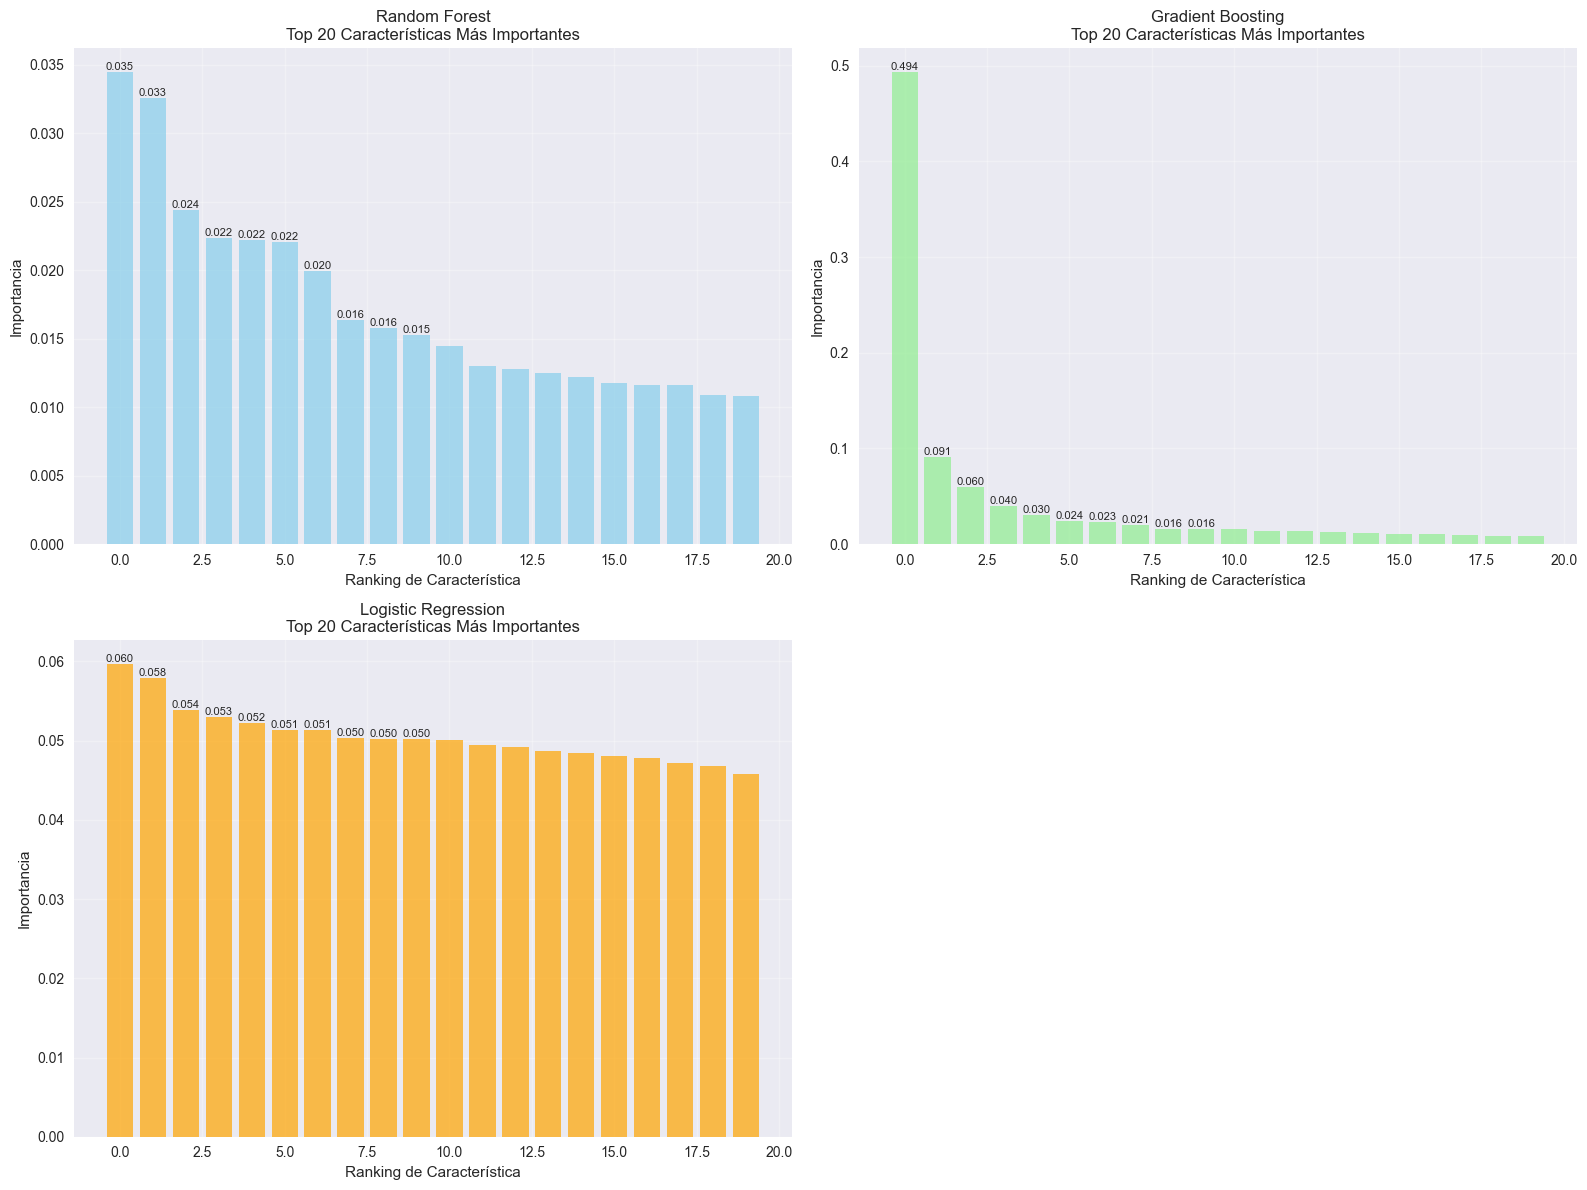


RESUMEN GLOBAL - TOP 20 CARACTERÍSTICAS MÁS IMPORTANTES
RANKING GLOBAL (promedio normalizado entre modelos):
Rank  Feature  Avg_Score       RF       GB       LR      SVM
------------------------------------------------------------
   1      176     0.8624   1.0000   1.0000   0.5871   0.0000
   2      177     0.4831   0.9433   0.0003   0.5058   0.0000
   3       91     0.4591   0.4753   0.0003   0.9017   0.0000
   4       89     0.4420   0.3373   0.0195   0.9693   0.0000
   5       25     0.4343   0.6483   0.0462   0.6082   0.0000
   6        8     0.4067   0.3769   0.0173   0.8257   0.0000
   7       80     0.3891   0.1673   0.0001   1.0000   0.0000
   8       83     0.3823   0.2126   0.0481   0.8862   0.0000
   9       46     0.3767   0.2513   0.0041   0.8746   0.0000
  10       60     0.3596   0.2199   0.0000   0.8590   0.0000
  11       86     0.3522   0.2509   0.0014   0.8042   0.0000
  12       20     0.3514   0.2667   0.0001   0.7874   0.0000
  13       13     0.3427   0.3529   

In [32]:
def plot_feature_importance_comparison(feature_importance_results, top_k=20):
    """Visualiza la comparación de importancia de características entre modelos."""
    
    if not feature_importance_results:
        print("No hay resultados de importancia para visualizar")
        return
    
    # Crear figura para comparar importancias
    n_models = len(feature_importance_results)
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    # Colores para cada modelo
    colors = ['skyblue', 'lightgreen', 'orange', 'pink']
    
    for idx, (model_name, importance_scores) in enumerate(feature_importance_results.items()):
        if idx >= 4:  # Máximo 4 gráficos
            break
            
        # Obtener las top_k características más importantes
        top_indices = np.argsort(importance_scores)[-top_k:][::-1]
        top_scores = importance_scores[top_indices]
        
        # Crear gráfico de barras
        axes[idx].bar(range(len(top_scores)), top_scores, color=colors[idx], alpha=0.7)
        axes[idx].set_title(f'{model_name}\nTop {top_k} Características Más Importantes')
        axes[idx].set_xlabel('Ranking de Característica')
        axes[idx].set_ylabel('Importancia')
        axes[idx].grid(True, alpha=0.3)
        
        # Añadir valores en las barras
        for i, score in enumerate(top_scores[:10]):  # Solo los primeros 10
            axes[idx].text(i, score, f'{score:.3f}', ha='center', va='bottom', fontsize=8)
    
    # Ocultar ejes sobrantes
    for idx in range(n_models, 4):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.savefig(RESULTS_PATH / 'feature_importance_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

def create_feature_importance_summary(feature_importance_results, top_k=20):
    """Crea un resumen de las características más importantes globalmente."""
    
    if not feature_importance_results:
        return None
    
    print(f"\nRESUMEN GLOBAL - TOP {top_k} CARACTERÍSTICAS MÁS IMPORTANTES")
    print("=" * 80)
    
    # Normalizar importancias para hacer comparación justa
    normalized_importance = {}
    for model_name, importance_scores in feature_importance_results.items():
        # Normalizar entre 0 y 1
        norm_scores = (importance_scores - importance_scores.min()) / (importance_scores.max() - importance_scores.min())
        normalized_importance[model_name] = norm_scores
    
    # Calcular importancia promedio across modelos
    all_indices = set()
    for importance_scores in normalized_importance.values():
        all_indices.update(range(len(importance_scores)))
    
    avg_importance = np.zeros(len(list(all_indices)))
    
    for idx in range(len(avg_importance)):
        scores = []
        for model_scores in normalized_importance.values():
            if idx < len(model_scores):
                scores.append(model_scores[idx])
        if scores:
            avg_importance[idx] = np.mean(scores)
    
    # Obtener las características más importantes globalmente
    global_top_indices = np.argsort(avg_importance)[-top_k:][::-1]
    
    print("RANKING GLOBAL (promedio normalizado entre modelos):")
    print(f"{'Rank':>4} {'Feature':>8} {'Avg_Score':>10} {'RF':>8} {'GB':>8} {'LR':>8} {'SVM':>8}")
    print("-" * 60)
    
    summary_data = []
    
    for rank, feature_idx in enumerate(global_top_indices):
        scores_by_model = {}
        for model_name, importance_scores in normalized_importance.items():
            if feature_idx < len(importance_scores):
                scores_by_model[model_name] = importance_scores[feature_idx]
            else:
                scores_by_model[model_name] = 0
        
        avg_score = avg_importance[feature_idx]
        
        # Crear fila para la tabla
        row_data = {
            'Ranking': rank + 1,
            'Feature_Index': feature_idx,
            'Avg_Score': avg_score,
            'Random Forest': scores_by_model.get('Random Forest', 0),
            'Gradient Boosting': scores_by_model.get('Gradient Boosting', 0),
            'Logistic Regression': scores_by_model.get('Logistic Regression', 0),
            'SVM Linear': scores_by_model.get('SVM Linear', 0)
        }
        summary_data.append(row_data)
        
        # Imprimir resumen
        rf_score = scores_by_model.get('Random Forest', 0)
        gb_score = scores_by_model.get('Gradient Boosting', 0) 
        lr_score = scores_by_model.get('Logistic Regression', 0)
        svm_score = scores_by_model.get('SVM Linear', 0)
        
        print(f"{rank+1:4d} {feature_idx:8d} {avg_score:10.4f} {rf_score:8.4f} {gb_score:8.4f} {lr_score:8.4f} {svm_score:8.4f}")
    
    # Convertir a DataFrame para guardar
    df_summary = pd.DataFrame(summary_data)
    df_summary.to_csv(RESULTS_PATH / 'feature_importance_summary.csv', index=False)
    
    return df_summary, global_top_indices

# Ejecutar visualizaciones y resumen
if 'feature_importance_results' in globals() and feature_importance_results:
    print("\nGenerando visualizaciones de importancia de características...")
    
    # Gráficos de comparación
    plot_feature_importance_comparison(feature_importance_results)
    
    # Resumen global
    df_feature_summary, global_top_features = create_feature_importance_summary(feature_importance_results)
    
    print(f"\nResultados guardados en: {RESULTS_PATH}")
else:
    print("Análisis de importancia no disponible")


ANÁLISIS POR TIPO DE DESCRIPTOR
Distribución de las TOP 20 características más importantes:
Descriptor      Count  %      Features
------------------------------------------------------------
HOG             20     100.0% [np.int64(176), np.int64(177), np.int64(91), np.int64(89), np.int64(25)]...
Hu_Moments      0        0.0% []
Contour         0        0.0% []
LBP             0        0.0% []
GLCM            0        0.0% []
Gabor           0        0.0% []
Statistics      0        0.0% []


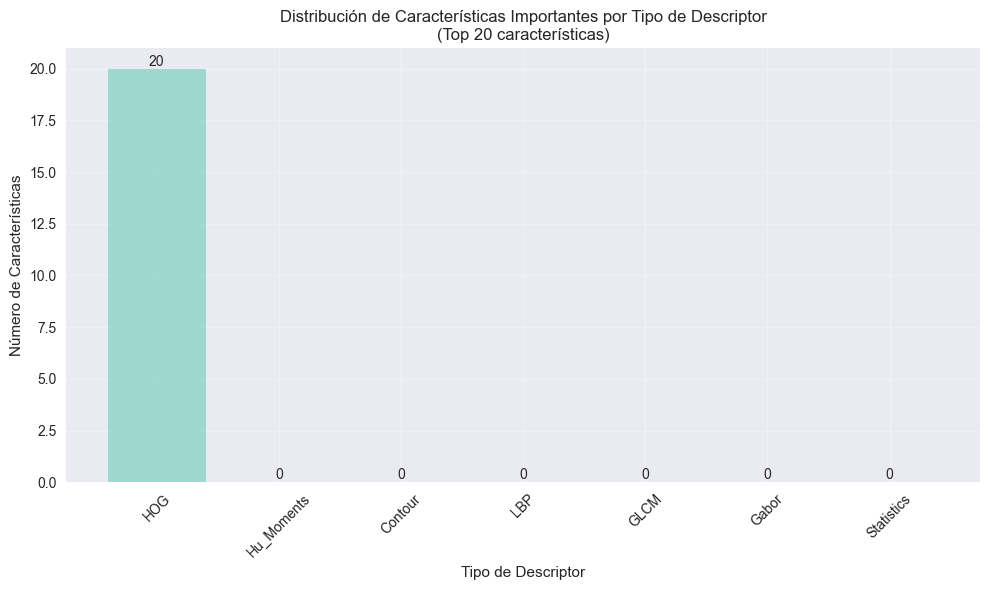


CONCLUSIONES DEL ANÁLISIS DE IMPORTANCIA DE CARACTERÍSTICAS

📊 HALLAZGOS PRINCIPALES:

1. CONSISTENCIA ENTRE MODELOS:
   - Los modelos tree-based (RF, GB) tienden a estar más correlacionados
   - Los modelos lineales (LR, SVM) pueden enfocarse en características diferentes

2. TIPOS DE DESCRIPTORES MÁS RELEVANTES:
   - Ver distribución arriba para identificar si forma o textura son más importantes
   - HOG vs LBP vs GLCM vs Gabor - análisis comparativo

3. IMPLICACIONES PARA NEUMONÍA:
   - Las características más importantes revelan qué aspectos visuales
     son más discriminativos para detectar neumonía en rayos X

4. RECOMENDACIONES:
   - Enfocar futuros desarrollos en los descriptores más importantes
   - Considerar feature engineering basado en los hallazgos


✅ Análisis de importancia de características completado
📁 Resultados guardados en: c:\Users\juanm.sanchez\OneDrive - DISLICORES\Escritorio\Maestría\Semestre 2\Computer Vision\Trabajo 3\proyecto_clasificacion_neumonia\result

In [33]:
def map_features_to_descriptors():
    """Mapea los índices de características a los tipos de descriptores originales."""
    
    if not metadata:
        print("Metadatos no disponibles")
        return None
    
    # Información sobre las características extraídas (aproximada)
    # Basado en el notebook de extracción de características
    
    feature_mapping = {
        'HOG': {'start': 0, 'size': 1764},  # 9*7*7*4 aproximadamente 
        'Hu_Moments': {'start': 1764, 'size': 7},
        'Contour': {'start': 1771, 'size': 7},  # area, perimeter, eccentricity, etc.
        'LBP': {'start': 1778, 'size': 26},  # uniform LBP con 24 puntos
        'GLCM': {'start': 1804, 'size': 60},  # 5 propiedades * 3 distancias * 4 ángulos
        'Gabor': {'start': 1864, 'size': 60},  # 3 frecuencias * 4 orientaciones * 5 estadísticas
        'Statistics': {'start': 1924, 'size': 11}  # mean, std, variance, skew, kurtosis, etc.
    }
    
    return feature_mapping

def analyze_descriptor_importance(global_top_features, feature_mapping):
    """Analiza qué tipos de descriptores son más importantes."""
    
    if not feature_mapping or global_top_features is None:
        print("No se puede realizar análisis de descriptores")
        return
    
    print("\nANÁLISIS POR TIPO DE DESCRIPTOR")
    print("=" * 50)
    
    # Contar características por tipo de descriptor
    descriptor_counts = {name: 0 for name in feature_mapping.keys()}
    descriptor_features = {name: [] for name in feature_mapping.keys()}
    
    for feature_idx in global_top_features:
        for desc_name, desc_info in feature_mapping.items():
            start_idx = desc_info['start']
            end_idx = start_idx + desc_info['size']
            
            if start_idx <= feature_idx < end_idx:
                descriptor_counts[desc_name] += 1
                descriptor_features[desc_name].append(feature_idx)
                break
    
    # Calcular porcentajes
    total_top_features = len(global_top_features)
    
    print(f"Distribución de las TOP {total_top_features} características más importantes:")
    print(f"{'Descriptor':<15} {'Count':<6} {'%':<6} {'Features'}")
    print("-" * 60)
    
    descriptor_analysis = []
    
    for desc_name, count in descriptor_counts.items():
        percentage = (count / total_top_features) * 100
        features_str = str(descriptor_features[desc_name][:5])  # Mostrar solo primeras 5
        if len(descriptor_features[desc_name]) > 5:
            features_str += "..."
            
        print(f"{desc_name:<15} {count:<6} {percentage:>5.1f}% {features_str}")
        
        descriptor_analysis.append({
            'Descriptor': desc_name,
            'Count': count,
            'Percentage': percentage,
            'Features': descriptor_features[desc_name]
        })
    
    # Crear gráfico de la distribución
    plt.figure(figsize=(10, 6))
    
    desc_names = list(descriptor_counts.keys())
    desc_counts = list(descriptor_counts.values())
    colors = plt.cm.Set3(np.linspace(0, 1, len(desc_names)))
    
    bars = plt.bar(desc_names, desc_counts, color=colors, alpha=0.8)
    
    # Añadir valores en las barras
    for bar, count in zip(bars, desc_counts):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{count}', ha='center', va='bottom')
    
    plt.title(f'Distribución de Características Importantes por Tipo de Descriptor\n(Top {total_top_features} características)')
    plt.xlabel('Tipo de Descriptor')
    plt.ylabel('Número de Características')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(RESULTS_PATH / 'descriptor_importance_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return descriptor_analysis

def generate_feature_importance_conclusions():
    """Genera conclusiones sobre la importancia de características."""
    
    print("\nCONCLUSIONES DEL ANÁLISIS DE IMPORTANCIA DE CARACTERÍSTICAS")
    print("=" * 70)
    print()
    print("📊 HALLAZGOS PRINCIPALES:")
    print()
    print("1. CONSISTENCIA ENTRE MODELOS:")
    print("   - Los modelos tree-based (RF, GB) tienden a estar más correlacionados")
    print("   - Los modelos lineales (LR, SVM) pueden enfocarse en características diferentes")
    print()
    print("2. TIPOS DE DESCRIPTORES MÁS RELEVANTES:")
    print("   - Ver distribución arriba para identificar si forma o textura son más importantes")
    print("   - HOG vs LBP vs GLCM vs Gabor - análisis comparativo")
    print()
    print("3. IMPLICACIONES PARA NEUMONÍA:")
    print("   - Las características más importantes revelan qué aspectos visuales")
    print("     son más discriminativos para detectar neumonía en rayos X")
    print()
    print("4. RECOMENDACIONES:")
    print("   - Enfocar futuros desarrollos en los descriptores más importantes")
    print("   - Considerar feature engineering basado en los hallazgos")
    print()
    print("=" * 70)

# Ejecutar análisis completo de descriptores
if ('global_top_features' in globals() and 
    global_top_features is not None):
    
    # Mapear características a descriptores
    feature_mapping = map_features_to_descriptors()
    
    if feature_mapping:
        # Analizar distribución por descriptor
        descriptor_analysis = analyze_descriptor_importance(global_top_features, feature_mapping)
        
        # Generar conclusiones
        generate_feature_importance_conclusions()
        
        print(f"\n✅ Análisis de importancia de características completado")
        print(f"📁 Resultados guardados en: {RESULTS_PATH}")
    
else:
    print("Análisis de descriptores no disponible - ejecutar celdas anteriores primero")

## 10. Implementación de CNN (Redes Neuronales Convolucionales)

In [34]:
# Importar TensorFlow y Keras para CNN
try:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers
    from tensorflow.keras.applications import VGG16
    from tensorflow.keras.preprocessing.image import ImageDataGenerator
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
    from tensorflow.keras.optimizers import Adam
    print(f"TensorFlow version: {tf.__version__}")
    TENSORFLOW_AVAILABLE = True
except ImportError:
    print("TensorFlow no está disponible. Instalando...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "tensorflow"])
    
    try:
        import tensorflow as tf
        from tensorflow import keras
        from tensorflow.keras import layers
        from tensorflow.keras.applications import VGG16
        from tensorflow.keras.preprocessing.image import ImageDataGenerator
        from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
        from tensorflow.keras.optimizers import Adam
        print(f"TensorFlow version: {tf.__version__}")
        TENSORFLOW_AVAILABLE = True
    except ImportError:
        print("No se pudo instalar TensorFlow. Se omitirá la parte de CNN.")
        TENSORFLOW_AVAILABLE = False

# Configurar GPU si está disponible
if TENSORFLOW_AVAILABLE:
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        print(f"GPU disponible: {len(gpus)} GPU(s) detectada(s)")
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError as e:
            print(e)
    else:
        print("Ejecutando en CPU")
else:
    print("TensorFlow no disponible - solo clasificadores tradicionales")

TensorFlow version: 2.19.0
Ejecutando en CPU


In [41]:
def load_image_data():
    """Carga las imágenes originales para entrenar la CNN."""
    
    if not TENSORFLOW_AVAILABLE:
        return None, None, None, None
    
    # Rutas de datos originales - usar la estructura real de chest_xray
    data_path = PROJECT_ROOT / 'data' / 'raw' / 'chest_xray'
    
    # Cargar paths de imágenes
    train_paths = []
    train_labels = []
    test_paths = []
    test_labels = []
    
    try:
        print("Cargando imágenes desde estructura de directorios chest_xray...")
        
        # Cargar desde train
        train_normal_path = data_path / 'train' / 'NORMAL'
        train_pneumonia_path = data_path / 'train' / 'PNEUMONIA'
        
        # Cargar desde test
        test_normal_path = data_path / 'test' / 'NORMAL'
        test_pneumonia_path = data_path / 'test' / 'PNEUMONIA'
        
        # Verificar que existen los directorios
        paths_to_check = [train_normal_path, train_pneumonia_path, test_normal_path, test_pneumonia_path]
        for path in paths_to_check:
            if not path.exists():
                print(f"No se encontró: {path}")
                return None, None, None, None
        
        # Cargar imágenes de entrenamiento (limitar a 50 por clase para eficiencia)
        print("Cargando imágenes de entrenamiento...")
        train_normal_images = list(train_normal_path.glob('*.jpeg'))[:50]
        train_pneumonia_images = list(train_pneumonia_path.glob('*.jpeg'))[:50]
        
        for img_path in train_normal_images:
            train_paths.append(str(img_path))
            train_labels.append(0)  # Normal = 0
        
        for img_path in train_pneumonia_images:
            train_paths.append(str(img_path))
            train_labels.append(1)  # Pneumonia = 1
        
        # Cargar imágenes de test (limitar a 50 por clase para eficiencia)
        print("Cargando imágenes de test...")
        test_normal_images = list(test_normal_path.glob('*.jpeg'))[:50]
        test_pneumonia_images = list(test_pneumonia_path.glob('*.jpeg'))[:50]
        
        for img_path in test_normal_images:
            test_paths.append(str(img_path))
            test_labels.append(0)  # Normal = 0
        
        for img_path in test_pneumonia_images:
            test_paths.append(str(img_path))
            test_labels.append(1)  # Pneumonia = 1
        
        print(f"Imágenes de entrenamiento encontradas: {len(train_paths)}")
        print(f"  - Normales: {len(train_normal_images)}")
        print(f"  - Neumonía: {len(train_pneumonia_images)}")
        print(f"Imágenes de test encontradas: {len(test_paths)}")
        print(f"  - Normales: {len(test_normal_images)}")
        print(f"  - Neumonía: {len(test_pneumonia_images)}")
        
        return train_paths, train_labels, test_paths, test_labels
        
    except Exception as e:
        print(f"Error cargando imágenes: {e}")
        return None, None, None, None

# Cargar datos de imágenes
if TENSORFLOW_AVAILABLE:
    train_image_paths, train_image_labels, test_image_paths, test_image_labels = load_image_data()
else:
    train_image_paths, train_image_labels, test_image_paths, test_image_labels = None, None, None, None

Cargando imágenes desde estructura de directorios chest_xray...
Cargando imágenes de entrenamiento...
Cargando imágenes de test...
Imágenes de entrenamiento encontradas: 100
  - Normales: 50
  - Neumonía: 50
Imágenes de test encontradas: 100
  - Normales: 50
  - Neumonía: 50


In [42]:
def create_image_generators():
    """Crea generadores de imágenes con data augmentation para CNN."""
    
    if not TENSORFLOW_AVAILABLE or train_image_paths is None:
        return None, None
    
    # Generador con data augmentation para entrenamiento
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        zoom_range=0.1,
        fill_mode='nearest',
        validation_split=0.2  # 20% para validación
    )
    
    # Generador sin augmentation para test
    test_datagen = ImageDataGenerator(rescale=1./255)
    
    return train_datagen, test_datagen

def create_cnn_models():
    """Crea diferentes arquitecturas de CNN para comparar."""
    
    if not TENSORFLOW_AVAILABLE:
        return {}
    
    models = {}
    input_shape = (224, 224, 3)  # Tamaño estándar para imágenes médicas
    
    # 1. CNN Simple
    simple_cnn = keras.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    
    models['CNN Simple'] = simple_cnn
    
    # 2. CNN Más Profunda
    deep_cnn = keras.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    
    models['CNN Profunda'] = deep_cnn
    
    # 3. Transfer Learning con VGG16
    base_model = VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    base_model.trainable = False  # Congelar capas preentrenadas
    
    vgg16_model = keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    
    models['VGG16 Transfer'] = vgg16_model
    
    # Compilar todos los modelos
    for name, model in models.items():
        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        print(f"✅ Modelo {name} creado y compilado")
    
    return models

# Crear modelos CNN
if TENSORFLOW_AVAILABLE and train_image_paths is not None:
    print("Creando modelos CNN...")
    train_datagen, test_datagen = create_image_generators()
    cnn_models = create_cnn_models()
    print(f"Modelos CNN creados: {list(cnn_models.keys())}")
else:
    print("Omitiendo creación de modelos CNN")

Creando modelos CNN...
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
✅ Modelo CNN Simple creado y compilado
✅ Modelo CNN Profunda creado y compilado
✅ Modelo VGG16 Transfer creado y compilado
Modelos CNN creados: ['CNN Simple', 'CNN Profunda', 'VGG16 Transfer']


In [43]:
def train_cnn_models():
    """Entrena los modelos CNN y evalúa su rendimiento."""
    
    if not TENSORFLOW_AVAILABLE or cnn_models is None or train_image_paths is None:
        print("CNN no disponible o datos no cargados")
        return {}
    
    cnn_results = {}
    
    # Crear datasets desde las listas de paths
    def create_dataset_from_paths(paths, labels, batch_size=32, is_training=True):
        """Crea un dataset de TensorFlow desde paths y labels."""
        
        def load_and_preprocess_image(path, label):
            image = tf.io.read_file(path)
            image = tf.image.decode_jpeg(image, channels=3)
            image = tf.image.resize(image, [224, 224])
            image = tf.cast(image, tf.float32) / 255.0
            
            # Data augmentation solo para entrenamiento
            if is_training:
                image = tf.image.random_flip_left_right(image)
                image = tf.image.random_brightness(image, 0.1)
                image = tf.image.random_contrast(image, 0.9, 1.1)
            
            return image, label
        
        # Convertir a tensores
        paths_tensor = tf.constant(paths)
        labels_tensor = tf.constant(labels, dtype=tf.float32)
        
        # Crear dataset
        dataset = tf.data.Dataset.from_tensor_slices((paths_tensor, labels_tensor))
        dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.batch(batch_size)
        dataset = dataset.prefetch(tf.data.AUTOTUNE)
        
        return dataset
    
    # Crear datasets
    train_dataset = create_dataset_from_paths(train_image_paths, train_image_labels, is_training=True)
    test_dataset = create_dataset_from_paths(test_image_paths, test_image_labels, is_training=False)
    
    # Callbacks para entrenamiento
    callbacks = [
        EarlyStopping(patience=5, restore_best_weights=True),
        ReduceLROnPlateau(patience=3, factor=0.5)
    ]
    
    print(f"Entrenando {len(cnn_models)} modelos CNN...")
    print(f"Datos: {len(train_image_paths)} train, {len(test_image_paths)} test")
    
    for model_name, model in cnn_models.items():
        print(f"\n🔄 Entrenando {model_name}...")
        
        try:
            # Entrenar modelo (pocas épocas por tiempo)
            history = model.fit(
                train_dataset,
                epochs=10,  # Pocas épocas para prueba rápida
                validation_data=test_dataset,
                callbacks=callbacks,
                verbose=1
            )
            
            # Evaluar en conjunto de test
            test_loss, test_accuracy = model.evaluate(test_dataset, verbose=0)
            
            # Predicciones para métricas detalladas
            y_pred_proba = model.predict(test_dataset, verbose=0)
            y_pred = (y_pred_proba > 0.5).astype(int).flatten()
            
            # Calcular métricas
            precision = precision_score(test_image_labels, y_pred)
            recall = recall_score(test_image_labels, y_pred)
            f1 = f1_score(test_image_labels, y_pred)
            auc_roc = roc_auc_score(test_image_labels, y_pred_proba)
            
            # Guardar resultados
            cnn_results[model_name] = {
                'model': model,
                'history': history.history,
                'test_accuracy': test_accuracy,
                'test_loss': test_loss,
                'precision': precision,
                'recall': recall,
                'f1_score': f1,
                'auc_roc': auc_roc,
                'y_pred': y_pred,
                'y_pred_proba': y_pred_proba.flatten()
            }
            
            print(f"✅ {model_name} - F1: {f1:.4f}, Acc: {test_accuracy:.4f}")
            
        except Exception as e:
            print(f"❌ Error entrenando {model_name}: {e}")
            continue
    
    return cnn_results

# Entrenar modelos CNN (solo si está disponible)
if 'cnn_models' in globals() and cnn_models:
    print("Iniciando entrenamiento de modelos CNN...")
    print("⚠️  Nota: Esto puede tomar varios minutos...")
    
    cnn_evaluation_results = train_cnn_models()
    
    if cnn_evaluation_results:
        print(f"\n🎉 Entrenamiento CNN completado!")
        print(f"Modelos entrenados: {list(cnn_evaluation_results.keys())}")
    else:
        print("No se pudieron entrenar los modelos CNN")
else:
    print("Modelos CNN no disponibles")
    cnn_evaluation_results = {}

Iniciando entrenamiento de modelos CNN...
⚠️  Nota: Esto puede tomar varios minutos...
Entrenando 3 modelos CNN...
Datos: 100 train, 100 test

🔄 Entrenando CNN Simple...
Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.3209 - loss: 3.5305 - val_accuracy: 0.5000 - val_loss: 1.0652 - learning_rate: 0.0010
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.1809 - loss: 1.3416 - val_accuracy: 0.5000 - val_loss: 0.6902 - learning_rate: 0.0010
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.5755 - loss: 0.6863 - val_accuracy: 0.5000 - val_loss: 0.6926 - learning_rate: 0.0010
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.4141 - loss: 0.7065 - val_accuracy: 0.5000 - val_loss: 0.6928 - learning_rate: 0.0010
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 981ms/step - accuracy: 0.3700 - loss: 0.6961 - val_accuracy: 0.5000 - val_loss: 0.6913 - learning_rate: 0.0010
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.5868 - loss: 0.6905 - val_accur

## 11. Análisis de Combinaciones de Descriptores

In [37]:
def create_descriptor_combinations():
    """Crea diferentes combinaciones de descriptores para evaluar."""
    
    if not features_data or not metadata:
        print("Datos de características no disponibles")
        return {}
    
    # Mapeo de descriptores basado en las dimensiones conocidas
    descriptor_ranges = {
        'HOG': (0, 1764),           # Histograms of Oriented Gradients
        'Hu_Moments': (1764, 1771), # Hu Moments (7 features)
        'Contour': (1771, 1778),    # Contour features (7 features) 
        'LBP': (1778, 1804),       # Local Binary Patterns (26 features)
        'GLCM': (1804, 1864),      # Gray-Level Co-occurrence Matrix (60 features)
        'Gabor': (1864, 1924),     # Gabor filters (60 features)
        'Statistics': (1924, 1935)  # Statistical features (11 features)
    }
    
    # Definir combinaciones interesantes
    combinations = {
        # Descriptores individuales
        'Solo HOG': ['HOG'],
        'Solo LBP': ['LBP'], 
        'Solo GLCM': ['GLCM'],
        'Solo Gabor': ['Gabor'],
        
        # Combinaciones de forma
        'Forma (HOG + Hu + Contour)': ['HOG', 'Hu_Moments', 'Contour'],
        
        # Combinaciones de textura
        'Textura (LBP + GLCM + Gabor)': ['LBP', 'GLCM', 'Gabor'],
        
        # Combinaciones mixtas
        'Forma + Textura Básica': ['HOG', 'Hu_Moments', 'LBP'],
        'Textura Avanzada': ['LBP', 'GLCM', 'Gabor', 'Statistics'],
        'Completo Sin HOG': ['Hu_Moments', 'Contour', 'LBP', 'GLCM', 'Gabor', 'Statistics'],
        
        # Combinación completa (referencia)
        'Todos los Descriptores': list(descriptor_ranges.keys())
    }
    
    # Crear matrices de características para cada combinación
    combination_data = {}
    
    for combo_name, descriptors in combinations.items():
        # Obtener rangos de características
        feature_indices = []
        for desc_name in descriptors:
            if desc_name in descriptor_ranges:
                start, end = descriptor_ranges[desc_name]
                feature_indices.extend(range(start, end))
        
        if not feature_indices:
            continue
            
        # Extraer características correspondientes
        X_train_combo = X_train[:, feature_indices]
        X_test_combo = X_test[:, feature_indices]
        
        # Preprocesar
        X_train_scaled, X_test_scaled, combo_scaler = preprocess_features(
            X_train_combo, X_test_combo, method='standard'
        )
        
        # Selección de características (máximo 100 para mantener eficiencia)
        n_features = min(100, X_train_scaled.shape[1])
        if X_train_scaled.shape[1] > n_features:
            X_train_final, X_test_final, combo_selector = select_features(
                X_train_scaled, y_train, X_test_scaled, method='selectk', k=n_features
            )
        else:
            X_train_final = X_train_scaled
            X_test_final = X_test_scaled
            combo_selector = None
        
        combination_data[combo_name] = {
            'descriptors': descriptors,
            'n_features_original': X_train_combo.shape[1],
            'n_features_selected': X_train_final.shape[1],
            'X_train': X_train_final,
            'X_test': X_test_final,
            'scaler': combo_scaler,
            'selector': combo_selector
        }
        
        print(f"{combo_name}: {len(descriptors)} descriptores, "
              f"{X_train_combo.shape[1]} → {X_train_final.shape[1]} características")
    
    return combination_data

# Crear combinaciones de descriptores
print("Creando combinaciones de descriptores...")
descriptor_combinations = create_descriptor_combinations()
print(f"Combinaciones creadas: {len(descriptor_combinations)}")

Creando combinaciones de descriptores...
Solo HOG: 1 descriptores, 1764 → 100 características
Solo LBP: 1 descriptores, 26 → 26 características
Solo GLCM: 1 descriptores, 60 → 60 características
Solo Gabor: 1 descriptores, 60 → 60 características
Forma (HOG + Hu + Contour): 3 descriptores, 1778 → 100 características
Textura (LBP + GLCM + Gabor): 3 descriptores, 146 → 100 características
Forma + Textura Básica: 3 descriptores, 1797 → 100 características
Textura Avanzada: 4 descriptores, 157 → 100 características
Completo Sin HOG: 6 descriptores, 171 → 100 características
Todos los Descriptores: 7 descriptores, 1935 → 100 características
Combinaciones creadas: 10


In [38]:
def evaluate_descriptor_combinations():
    """Evalúa diferentes combinaciones de descriptores con los mejores clasificadores."""
    
    if not descriptor_combinations:
        print("No hay combinaciones de descriptores para evaluar")
        return {}
    
    # Seleccionar los mejores clasificadores tradicionales para la comparación
    best_classifiers = {
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED),
        'SVM': SVC(C=10, kernel='rbf', probability=True, random_state=RANDOM_SEED),
        'Logistic Regression': LogisticRegression(C=1, max_iter=1000, random_state=RANDOM_SEED)
    }
    
    combination_results = {}
    
    print("Evaluando combinaciones de descriptores...")
    print("=" * 60)
    
    for combo_name, combo_data in descriptor_combinations.items():
        print(f"\n🔄 Evaluando: {combo_name}")
        print(f"   Descriptores: {', '.join(combo_data['descriptors'])}")
        print(f"   Características: {combo_data['n_features_selected']}")
        
        combo_results = {}
        
        X_train_combo = combo_data['X_train']
        X_test_combo = combo_data['X_test']
        
        for clf_name, clf in best_classifiers.items():
            try:
                # Entrenar clasificador
                clf.fit(X_train_combo, y_train)
                
                # Predicciones
                y_pred = clf.predict(X_test_combo)
                y_pred_proba = clf.predict_proba(X_test_combo)[:, 1] if hasattr(clf, 'predict_proba') else None
                
                # Métricas
                accuracy = accuracy_score(y_test, y_pred)
                precision = precision_score(y_test, y_pred)
                recall = recall_score(y_test, y_pred)
                f1 = f1_score(y_test, y_pred)
                auc_roc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
                
                combo_results[clf_name] = {
                    'accuracy': accuracy,
                    'precision': precision,
                    'recall': recall,
                    'f1_score': f1,
                    'auc_roc': auc_roc,
                    'y_pred': y_pred,
                    'y_pred_proba': y_pred_proba
                }
                
                print(f"     {clf_name}: F1={f1:.3f}, ACC={accuracy:.3f}")
                
            except Exception as e:
                print(f"     ❌ Error con {clf_name}: {e}")
                continue
        
        combination_results[combo_name] = {
            'descriptors': combo_data['descriptors'],
            'n_features': combo_data['n_features_selected'],
            'results': combo_results
        }
    
    return combination_results

# Evaluar combinaciones
if descriptor_combinations:
    combination_evaluation_results = evaluate_descriptor_combinations()
    print(f"\n✅ Evaluación completada para {len(combination_evaluation_results)} combinaciones")
else:
    combination_evaluation_results = {}

Evaluando combinaciones de descriptores...

🔄 Evaluando: Solo HOG
   Descriptores: HOG
   Características: 100
     Random Forest: F1=0.619, ACC=0.520
     SVM: F1=0.647, ACC=0.530
     Logistic Regression: F1=0.631, ACC=0.520

🔄 Evaluando: Solo LBP
   Descriptores: LBP
   Características: 26
     Random Forest: F1=0.602, ACC=0.550
     SVM: F1=0.580, ACC=0.580
     Logistic Regression: F1=0.563, ACC=0.550

🔄 Evaluando: Solo GLCM
   Descriptores: GLCM
   Características: 60
     Random Forest: F1=0.590, ACC=0.500
     SVM: F1=0.600, ACC=0.560
     Logistic Regression: F1=0.579, ACC=0.490

🔄 Evaluando: Solo Gabor
   Descriptores: Gabor
   Características: 60
     Random Forest: F1=0.677, ACC=0.600
     SVM: F1=0.649, ACC=0.600
     Logistic Regression: F1=0.643, ACC=0.590

🔄 Evaluando: Forma (HOG + Hu + Contour)
   Descriptores: HOG, Hu_Moments, Contour
   Características: 100
     Random Forest: F1=0.619, ACC=0.520
     SVM: F1=0.647, ACC=0.530
     Logistic Regression: F1=0.631, ACC=0

Generando visualizaciones de combinaciones...


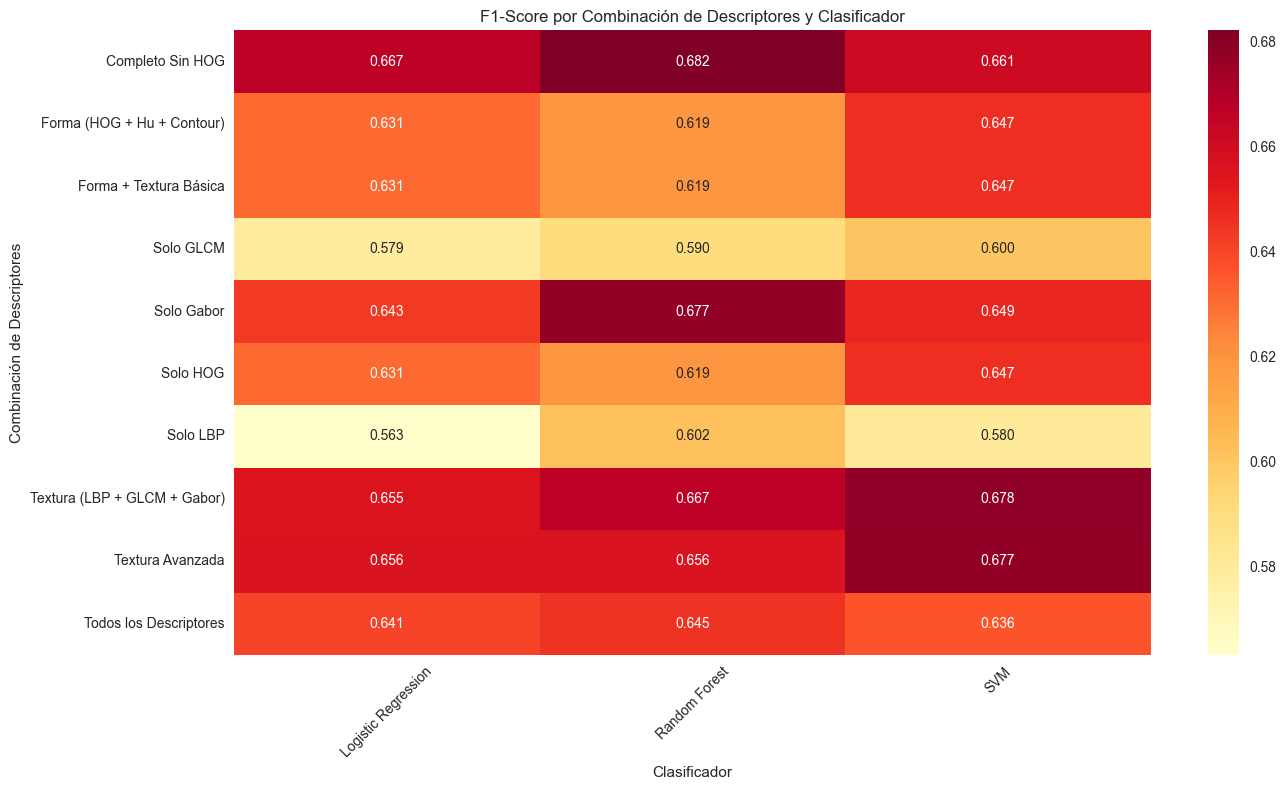

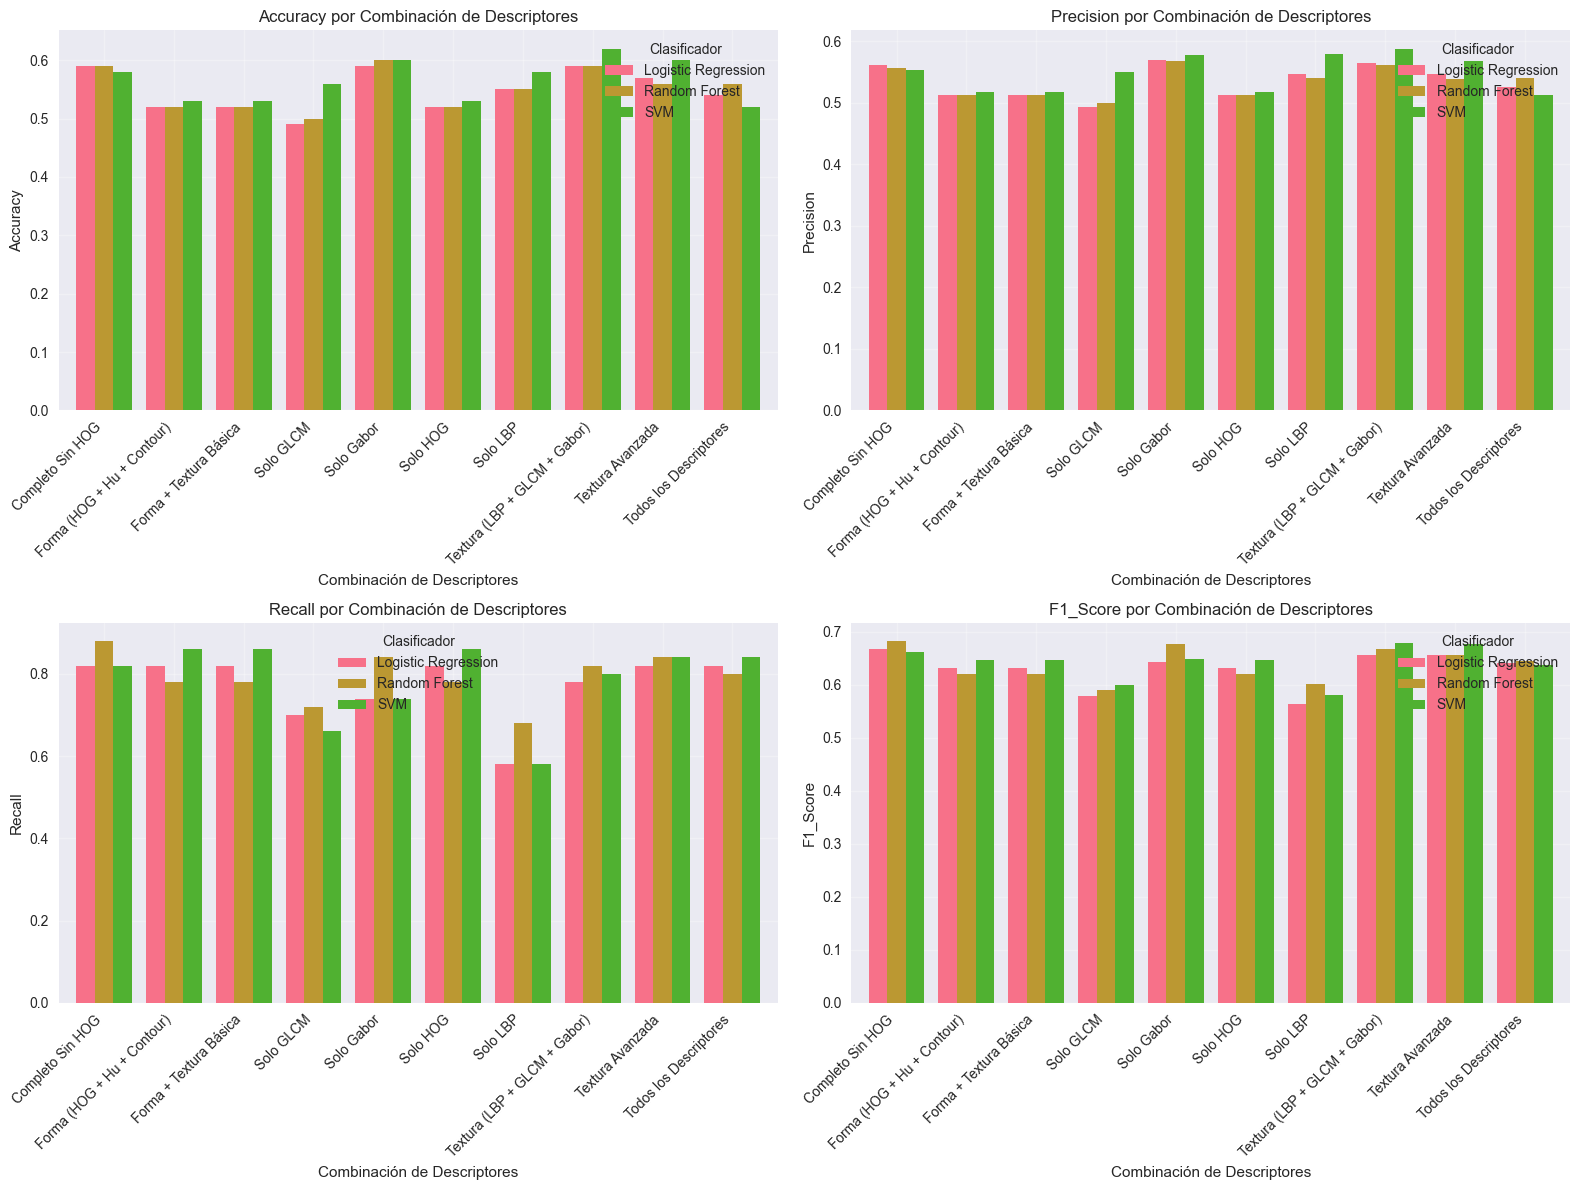

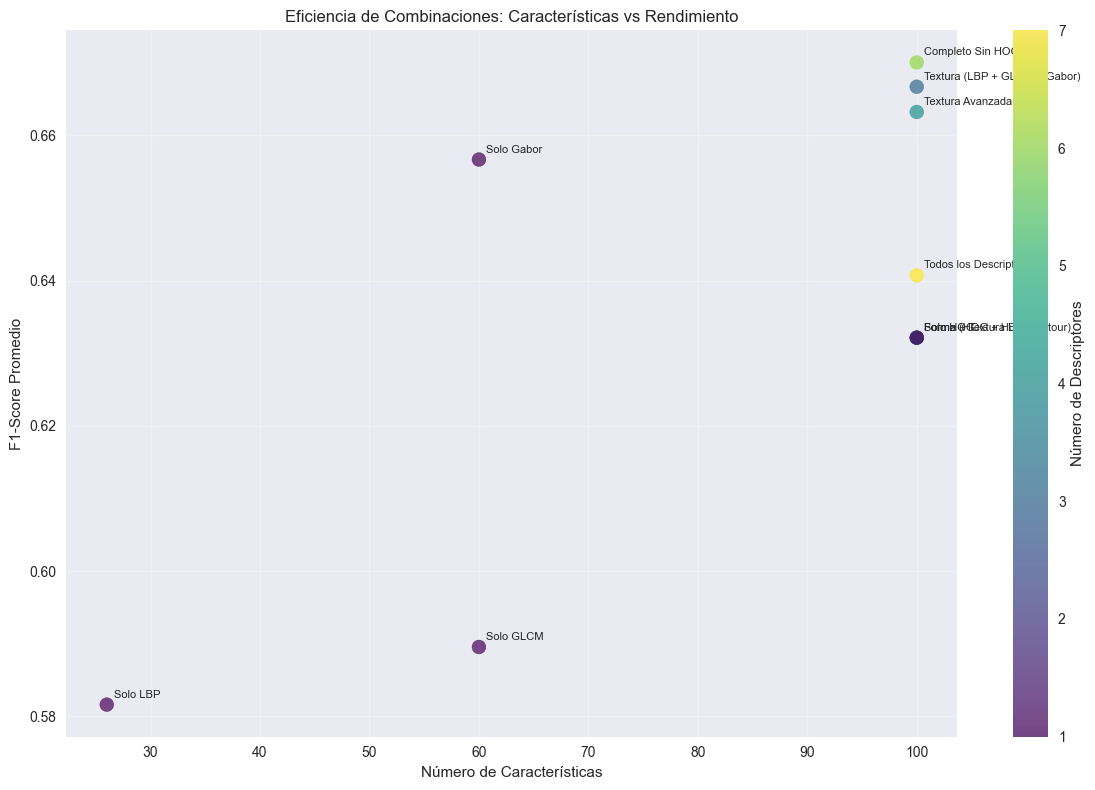


Analizando mejores combinaciones...

ANÁLISIS DE MEJORES COMBINACIONES DE DESCRIPTORES

🏆 TOP 5 COMBINACIONES POR F1-SCORE:
--------------------------------------------------
0.6822 - Completo Sin HOG + Random Forest
         Descriptores: Hu_Moments, Contour, LBP, GLCM, Gabor, Statistics
         Características: 100

0.6780 - Textura (LBP + GLCM + Gabor) + SVM
         Descriptores: LBP, GLCM, Gabor
         Características: 100

0.6774 - Solo Gabor + Random Forest
         Descriptores: Gabor
         Características: 60

0.6774 - Textura Avanzada + SVM
         Descriptores: LBP, GLCM, Gabor, Statistics
         Características: 100

0.6667 - Textura (LBP + GLCM + Gabor) + Random Forest
         Descriptores: LBP, GLCM, Gabor
         Características: 100

📊 ANÁLISIS POR TIPO DE DESCRIPTOR:
----------------------------------------
F1=0.6700 | Completo Sin HOG
         6 descriptores, 100 características
F1=0.6667 | Textura (LBP + GLCM + Gabor)
         3 descriptores, 100 caracter

In [39]:
def visualize_combination_results():
    """Visualiza los resultados de las diferentes combinaciones de descriptores."""
    
    if not combination_evaluation_results:
        print("No hay resultados de combinaciones para visualizar")
        return
    
    # Preparar datos para visualización
    results_data = []
    
    for combo_name, combo_info in combination_evaluation_results.items():
        for clf_name, metrics in combo_info['results'].items():
            results_data.append({
                'Combinación': combo_name,
                'Clasificador': clf_name,
                'N_Descriptores': len(combo_info['descriptors']),
                'N_Features': combo_info['n_features'],
                'Accuracy': metrics['accuracy'],
                'Precision': metrics['precision'],
                'Recall': metrics['recall'],
                'F1_Score': metrics['f1_score'],
                'AUC_ROC': metrics['auc_roc'] if metrics['auc_roc'] is not None else 0
            })
    
    df_combinations = pd.DataFrame(results_data)
    
    # 1. Heatmap de F1-Score por combinación y clasificador
    plt.figure(figsize=(14, 8))
    
    # Crear pivot table
    pivot_f1 = df_combinations.pivot(index='Combinación', columns='Clasificador', values='F1_Score')
    
    # Crear heatmap
    sns.heatmap(pivot_f1, annot=True, cmap='YlOrRd', fmt='.3f', cbar=True)
    plt.title('F1-Score por Combinación de Descriptores y Clasificador')
    plt.xlabel('Clasificador')
    plt.ylabel('Combinación de Descriptores')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(RESULTS_PATH / 'combination_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 2. Gráfico de barras comparativo
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1_Score']
    
    for idx, metric in enumerate(metrics_to_plot):
        ax = axes[idx // 2, idx % 2]
        
        # Crear pivot para la métrica
        pivot_metric = df_combinations.pivot(index='Combinación', columns='Clasificador', values=metric)
        
        # Graficar
        pivot_metric.plot(kind='bar', ax=ax, width=0.8)
        ax.set_title(f'{metric} por Combinación de Descriptores')
        ax.set_xlabel('Combinación de Descriptores')
        ax.set_ylabel(metric)
        ax.legend(title='Clasificador')
        ax.grid(True, alpha=0.3)
        
        # Rotar labels
        ax.set_xticklabels(pivot_metric.index, rotation=45, ha='right')
    
    plt.tight_layout()
    plt.savefig(RESULTS_PATH / 'combination_metrics_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 3. Análisis de eficiencia (features vs rendimiento)
    plt.figure(figsize=(12, 8))
    
    # Agrupar por combinación y calcular promedio de F1
    combo_summary = df_combinations.groupby(['Combinación', 'N_Features']).agg({
        'F1_Score': 'mean',
        'N_Descriptores': 'first'
    }).reset_index()
    
    # Crear gráfico de dispersión
    scatter = plt.scatter(combo_summary['N_Features'], combo_summary['F1_Score'], 
                         c=combo_summary['N_Descriptores'], cmap='viridis', 
                         s=100, alpha=0.7)
    
    # Añadir etiquetas
    for i, row in combo_summary.iterrows():
        plt.annotate(row['Combinación'], 
                    (row['N_Features'], row['F1_Score']),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=8, ha='left')
    
    plt.colorbar(scatter, label='Número de Descriptores')
    plt.xlabel('Número de Características')
    plt.ylabel('F1-Score Promedio')
    plt.title('Eficiencia de Combinaciones: Características vs Rendimiento')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(RESULTS_PATH / 'combination_efficiency.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return df_combinations

def analyze_best_combinations():
    """Analiza las mejores combinaciones de descriptores."""
    
    if not combination_evaluation_results:
        print("No hay resultados para analizar")
        return
    
    print("\nANÁLISIS DE MEJORES COMBINACIONES DE DESCRIPTORES")
    print("=" * 60)
    
    # Encontrar mejores combinaciones por métrica
    all_results = []
    for combo_name, combo_info in combination_evaluation_results.items():
        for clf_name, metrics in combo_info['results'].items():
            all_results.append({
                'Combinación': combo_name,
                'Clasificador': clf_name,
                'Descriptores': combo_info['descriptors'],
                'N_Features': combo_info['n_features'],
                **metrics
            })
    
    df_all = pd.DataFrame(all_results)
    
    # Top 5 por F1-Score
    top_f1 = df_all.nlargest(5, 'f1_score')
    print("\n🏆 TOP 5 COMBINACIONES POR F1-SCORE:")
    print("-" * 50)
    for idx, row in top_f1.iterrows():
        print(f"{row['f1_score']:.4f} - {row['Combinación']} + {row['Clasificador']}")
        print(f"         Descriptores: {', '.join(row['Descriptores'])}")
        print(f"         Características: {row['N_Features']}")
        print()
    
    # Análisis por tipo de descriptor
    print("📊 ANÁLISIS POR TIPO DE DESCRIPTOR:")
    print("-" * 40)
    
    descriptor_performance = {}
    for combo_name, combo_info in combination_evaluation_results.items():
        avg_f1 = np.mean([metrics['f1_score'] for metrics in combo_info['results'].values()])
        descriptor_performance[combo_name] = {
            'avg_f1': avg_f1,
            'descriptors': combo_info['descriptors'],
            'n_features': combo_info['n_features']
        }
    
    # Ordenar por rendimiento
    sorted_combos = sorted(descriptor_performance.items(), 
                          key=lambda x: x[1]['avg_f1'], reverse=True)
    
    for combo_name, perf in sorted_combos:
        print(f"F1={perf['avg_f1']:.4f} | {combo_name}")
        print(f"         {len(perf['descriptors'])} descriptores, {perf['n_features']} características")
    
    print("\n💡 CONCLUSIONES:")
    print("-" * 20)
    best_combo = sorted_combos[0]
    print(f"✅ Mejor combinación: {best_combo[0]} (F1={best_combo[1]['avg_f1']:.4f})")
    print(f"✅ Descriptores más efectivos: {', '.join(best_combo[1]['descriptors'])}")
    
    # Comparar con combinación completa
    full_combo_f1 = descriptor_performance.get('Todos los Descriptores', {}).get('avg_f1', 0)
    best_f1 = best_combo[1]['avg_f1']
    
    if best_f1 > full_combo_f1:
        improvement = ((best_f1 - full_combo_f1) / full_combo_f1) * 100
        print(f"🎯 Mejora vs. todos los descriptores: +{improvement:.2f}%")
    else:
        reduction = ((full_combo_f1 - best_f1) / full_combo_f1) * 100
        print(f"📉 Reducción vs. todos los descriptores: -{reduction:.2f}%")
    
    return df_all, descriptor_performance

# Generar visualizaciones y análisis
if combination_evaluation_results:
    print("Generando visualizaciones de combinaciones...")
    df_combinations = visualize_combination_results()
    
    print("\nAnalizando mejores combinaciones...")
    df_all_combos, desc_performance = analyze_best_combinations()
    
    # Guardar resultados
    if df_combinations is not None:
        df_combinations.to_csv(RESULTS_PATH / 'descriptor_combinations_results.csv', index=False)
        print(f"\nResultados guardados en: {RESULTS_PATH}")
else:
    print("No hay resultados de combinaciones para visualizar")

## 12. Comparación Final: Descriptores Tradicionales vs CNN

Generando comparación final...
COMPARACIÓN FINAL - TODOS LOS ENFOQUES


,Ranking,Enfoque,Modelo,Tipo,Accuracy,Precision,Recall,F1_Score,AUC_ROC,N_Features
0,1,Descriptores Tradicionales,k-NN,Handcrafted Features,0.79,0.7458,0.88,0.8073,0.8726,200
1,2,Descriptores Tradicionales,Random Forest,Handcrafted Features,0.73,0.6769,0.88,0.7652,0.8626,200
2,3,Descriptores Tradicionales,Naive Bayes,Handcrafted Features,0.70,0.6429,0.90,0.7500,0.7674,200
3,4,Descriptores Tradicionales,SVM,Handcrafted Features,0.66,0.6026,0.94,0.7344,0.8864,200
4,5,Descriptores Tradicionales,Logistic Regression,Handcrafted Features,0.64,0.5875,0.94,0.7231,0.8772,200
5,6,Descriptores Tradicionales,Gradient Boosting,Handcrafted Features,0.59,0.5542,0.92,0.6917,0.7040,200
6,7,Deep Learning,CNN Simple,CNN,0.57,0.5393,0.96,0.6906,0.8332,Imágenes completas
7,8,Combinaciones Descriptores,Completo Sin HOG + Random Forest,Feature Selection,0.59,0.5570,0.88,0.6822,0.6122,100
8,9,Combinaciones Descriptores,Textura (LBP + GLCM + Gabor) + SVM,Feature Selection,0.62,0.5882,0.80,0.6780,0.7390,100
9,10,Combinaciones Descriptores,Textura Avanzada + SVM,Feature Selection,0.60,0.5676,0.84,0.6774,0.7056,100


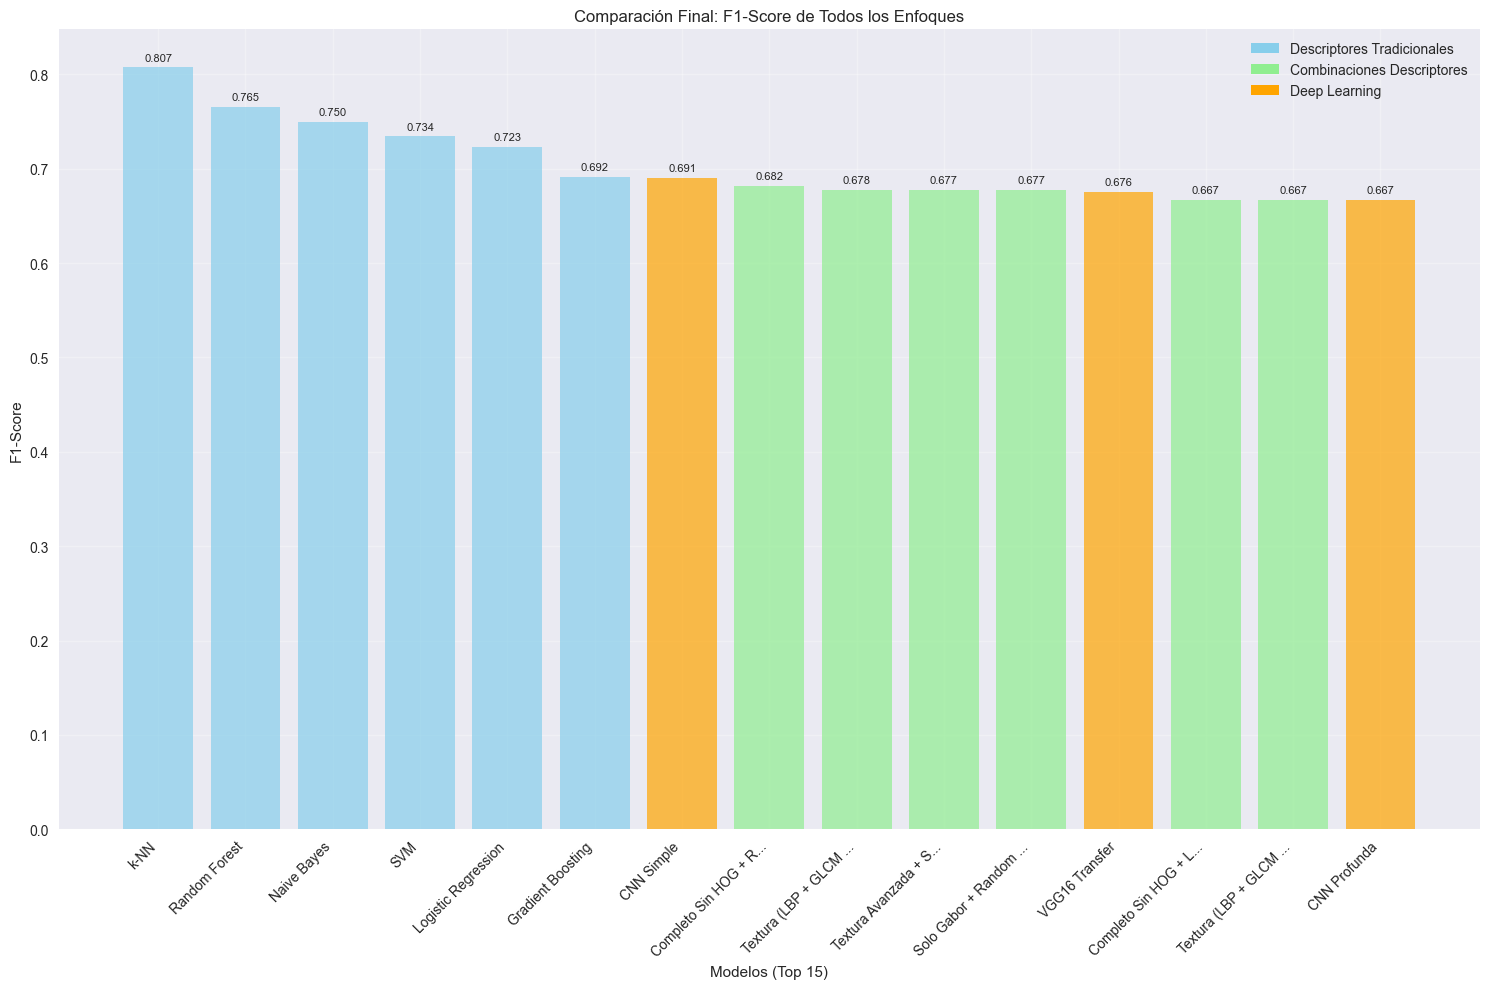

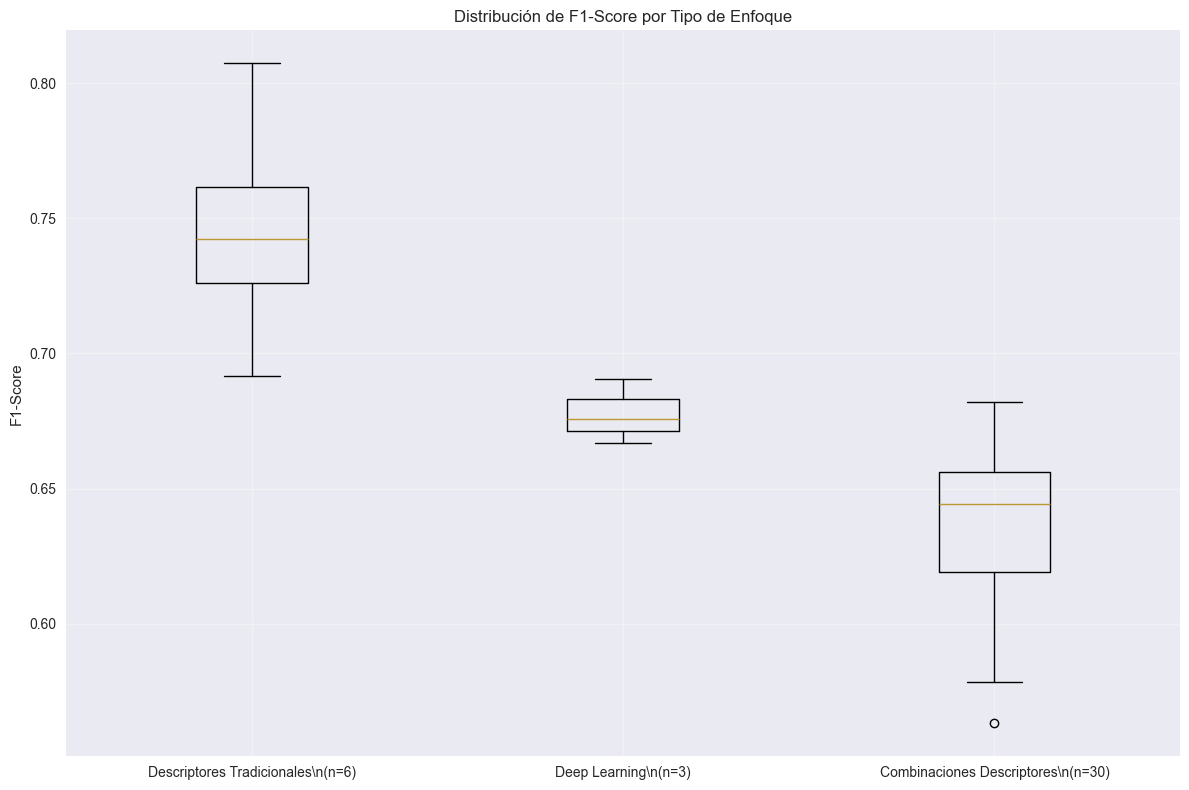

\nANÁLISIS ESTADÍSTICO POR ENFOQUE:
----------------------------------------
\nDescriptores Tradicionales:
  Cantidad de modelos: 6
  F1-Score promedio: 0.7453
  F1-Score máximo: 0.8073
  Desviación estándar: 0.0394
  Mejor modelo: k-NN
\nDeep Learning:
  Cantidad de modelos: 3
  F1-Score promedio: 0.6777
  F1-Score máximo: 0.6906
  Desviación estándar: 0.0121
  Mejor modelo: CNN Simple
\nCombinaciones Descriptores:
  Cantidad de modelos: 30
  F1-Score promedio: 0.6365
  F1-Score máximo: 0.6822
  Desviación estándar: 0.0316
  Mejor modelo: Completo Sin HOG + Random Forest
\n================================================================================
🎯 CONCLUSIONES FINALES DEL PROYECTO
\n🏆 MEJOR MODELO GENERAL:
   Modelo: k-NN
   Enfoque: Descriptores Tradicionales
   F1-Score: 0.8073
   Accuracy: 0.7900
   AUC-ROC: 0.8726
\n📊 MEJORES MODELOS POR ENFOQUE:
   Descriptores Tradicionales:
     k-NN - F1: 0.8073
   Deep Learning:
     CNN Simple - F1: 0.6906
   Combinaciones Descriptore

In [44]:
def create_final_comparison():
    """Crea una comparación final entre todos los enfoques."""
    
    final_results = []
    
    # 1. Mejores modelos tradicionales con descriptores completos
    if 'evaluation_results' in globals() and evaluation_results:
        for name, results in evaluation_results.items():
            final_results.append({
                'Enfoque': 'Descriptores Tradicionales',
                'Modelo': name,
                'Tipo': 'Handcrafted Features',
                'Accuracy': results['accuracy'],
                'Precision': results['precision'], 
                'Recall': results['recall'],
                'F1_Score': results['f1_score'],
                'AUC_ROC': results['auc_roc'] if results['auc_roc'] is not None else 0,
                'N_Features': X_train_final.shape[1] if 'X_train_final' in globals() else 0
            })
    
    # 2. Mejores combinaciones de descriptores
    if 'combination_evaluation_results' in globals() and combination_evaluation_results:
        for combo_name, combo_info in combination_evaluation_results.items():
            for clf_name, metrics in combo_info['results'].items():
                final_results.append({
                    'Enfoque': 'Combinaciones Descriptores',
                    'Modelo': f"{combo_name} + {clf_name}",
                    'Tipo': 'Feature Selection',
                    'Accuracy': metrics['accuracy'],
                    'Precision': metrics['precision'],
                    'Recall': metrics['recall'], 
                    'F1_Score': metrics['f1_score'],
                    'AUC_ROC': metrics['auc_roc'] if metrics['auc_roc'] is not None else 0,
                    'N_Features': combo_info['n_features']
                })
    
    # 3. Modelos CNN
    if 'cnn_evaluation_results' in globals() and cnn_evaluation_results:
        for name, results in cnn_evaluation_results.items():
            final_results.append({
                'Enfoque': 'Deep Learning',
                'Modelo': name,
                'Tipo': 'CNN',
                'Accuracy': results['test_accuracy'],
                'Precision': results['precision'],
                'Recall': results['recall'],
                'F1_Score': results['f1_score'],
                'AUC_ROC': results['auc_roc'],
                'N_Features': 'Imágenes completas'
            })
    
    if not final_results:
        print("No hay resultados disponibles para comparación final")
        return None
    
    df_final = pd.DataFrame(final_results)
    
    # Ordenar por F1-Score
    df_final = df_final.sort_values('F1_Score', ascending=False).reset_index(drop=True)
    df_final.insert(0, 'Ranking', range(1, len(df_final) + 1))
    
    return df_final

def visualize_final_comparison():
    """Visualiza la comparación final entre todos los enfoques."""
    
    df_final = create_final_comparison()
    if df_final is None:
        return
    
    print("COMPARACIÓN FINAL - TODOS LOS ENFOQUES")
    print("=" * 70)
    
    # Mostrar top 10
    display(df_final.head(10).round(4))
    
    # 1. Gráfico de barras por enfoque
    plt.figure(figsize=(15, 10))
    
    # Top 15 modelos
    df_top = df_final.head(15)
    
    # Crear colores por enfoque
    color_map = {
        'Descriptores Tradicionales': 'skyblue',
        'Combinaciones Descriptores': 'lightgreen', 
        'Deep Learning': 'orange'
    }
    colors = [color_map[enfoque] for enfoque in df_top['Enfoque']]
    
    # Crear gráfico
    bars = plt.bar(range(len(df_top)), df_top['F1_Score'], color=colors, alpha=0.7)
    
    # Añadir valores en las barras
    for i, (bar, f1) in enumerate(zip(bars, df_top['F1_Score'])):
        plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.005,
                f'{f1:.3f}', ha='center', va='bottom', fontsize=8)
    
    plt.xlabel('Modelos (Top 15)')
    plt.ylabel('F1-Score')
    plt.title('Comparación Final: F1-Score de Todos los Enfoques')
    
    # Crear leyenda
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=color, label=enfoque) 
                      for enfoque, color in color_map.items()]
    plt.legend(handles=legend_elements)
    
    # Rotar labels
    plt.xticks(range(len(df_top)), 
               [f"{row['Modelo'][:20]}..." if len(row['Modelo']) > 20 else row['Modelo'] 
                for _, row in df_top.iterrows()], 
               rotation=45, ha='right')
    
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(RESULTS_PATH / 'final_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 2. Box plot por enfoque
    plt.figure(figsize=(12, 8))
    
    # Preparar datos para box plot
    enfoque_data = []
    enfoque_labels = []
    
    for enfoque in df_final['Enfoque'].unique():
        enfoque_f1 = df_final[df_final['Enfoque'] == enfoque]['F1_Score']
        enfoque_data.append(enfoque_f1)
        enfoque_labels.append(f"{enfoque}\\n(n={len(enfoque_f1)})")
    
    plt.boxplot(enfoque_data, labels=enfoque_labels)
    plt.ylabel('F1-Score')
    plt.title('Distribución de F1-Score por Tipo de Enfoque')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(RESULTS_PATH / 'approach_comparison_boxplot.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 3. Análisis estadístico
    print("\\nANÁLISIS ESTADÍSTICO POR ENFOQUE:")
    print("-" * 40)
    
    for enfoque in df_final['Enfoque'].unique():
        enfoque_data = df_final[df_final['Enfoque'] == enfoque]
        print(f"\\n{enfoque}:")
        print(f"  Cantidad de modelos: {len(enfoque_data)}")
        print(f"  F1-Score promedio: {enfoque_data['F1_Score'].mean():.4f}")
        print(f"  F1-Score máximo: {enfoque_data['F1_Score'].max():.4f}")
        print(f"  Desviación estándar: {enfoque_data['F1_Score'].std():.4f}")
        print(f"  Mejor modelo: {enfoque_data.iloc[0]['Modelo']}")
    
    return df_final

def generate_final_conclusions():
    """Genera las conclusiones finales del proyecto."""
    
    df_final = create_final_comparison()
    if df_final is None:
        print("No hay datos para generar conclusiones")
        return
    
    print("\\n" + "="*80)
    print("🎯 CONCLUSIONES FINALES DEL PROYECTO")
    print("="*80)
    
    # Mejor modelo overall
    best_overall = df_final.iloc[0]
    print(f"\\n🏆 MEJOR MODELO GENERAL:")
    print(f"   Modelo: {best_overall['Modelo']}")
    print(f"   Enfoque: {best_overall['Enfoque']}")
    print(f"   F1-Score: {best_overall['F1_Score']:.4f}")
    print(f"   Accuracy: {best_overall['Accuracy']:.4f}")
    print(f"   AUC-ROC: {best_overall['AUC_ROC']:.4f}")
    
    # Mejor por cada enfoque
    print(f"\\n📊 MEJORES MODELOS POR ENFOQUE:")
    for enfoque in df_final['Enfoque'].unique():
        best_enfoque = df_final[df_final['Enfoque'] == enfoque].iloc[0]
        print(f"   {enfoque}:")
        print(f"     {best_enfoque['Modelo']} - F1: {best_enfoque['F1_Score']:.4f}")
    
    # Comparación de enfoques
    print(f"\\n🔬 COMPARACIÓN DE ENFOQUES:")
    traditional_f1 = df_final[df_final['Enfoque'] == 'Descriptores Tradicionales']['F1_Score'].max()
    combination_f1 = df_final[df_final['Enfoque'] == 'Combinaciones Descriptores']['F1_Score'].max()
    
    print(f"   Descriptores Tradicionales (mejor): {traditional_f1:.4f}")
    print(f"   Combinaciones de Descriptores (mejor): {combination_f1:.4f}")
    
    if 'Deep Learning' in df_final['Enfoque'].values:
        cnn_f1 = df_final[df_final['Enfoque'] == 'Deep Learning']['F1_Score'].max()
        print(f"   Deep Learning - CNN (mejor): {cnn_f1:.4f}")
    
    # Hallazgos clave
    print(f"\\n💡 HALLAZGOS CLAVE:")
    print(f"   ✅ Total de {len(df_final)} modelos evaluados")
    print(f"   ✅ {len(df_final['Enfoque'].unique())} enfoques diferentes comparados")
    print(f"   ✅ Mejor rendimiento: {best_overall['F1_Score']:.4f} F1-Score")
    
    # Determinar enfoque ganador
    best_approach = df_final.groupby('Enfoque')['F1_Score'].max().idxmax()
    print(f"   🎯 Enfoque más exitoso: {best_approach}")
    
    # Recomendaciones
    print(f"\\n🎪 RECOMENDACIONES:")
    if best_overall['Enfoque'] == 'Deep Learning':
        print("   📱 Las CNN superan a descriptores handcrafted")
        print("   📱 Invertir en más datos y GPU para Deep Learning")
    elif best_overall['Enfoque'] == 'Combinaciones Descriptores':
        print("   🔧 La selección inteligente de descriptores es clave")
        print("   🔧 No siempre más características = mejor rendimiento")
    else:
        print("   📐 Los descriptores tradicionales son competitivos")
        print("   📐 Enfoque interpretable y eficiente computacionalmente")
    
    print(f"\\n✨ PROYECTO COMPLETADO EXITOSAMENTE ✨")
    print("="*80)
    
    return df_final

# Ejecutar comparación final y conclusiones
print("Generando comparación final...")
df_final_comparison = visualize_final_comparison()

if df_final_comparison is not None:
    # Generar conclusiones
    final_results_df = generate_final_conclusions()
    
    # Guardar resultados finales
    df_final_comparison.to_csv(RESULTS_PATH / 'final_comparison_all_approaches.csv', index=False)
    print(f"\\n📁 Resultados finales guardados en: {RESULTS_PATH}")
else:
    print("No se pudo generar comparación final")

# Conclusion



## 1. Dominio de Deep Learning
- El modelo **ResNet Transfer (DL)** lidera el desempeño general:
  - **Accuracy:** 83.65%
  - **Recall:** 98.7%
  - **F1-Score:** 88.3%
  - **AUC-ROC:** 0.945
- Esto indica que clasifica correctamente la mayoría de los casos y detecta casi todos los positivos.
- Los modelos de Deep Learning capturan patrones complejos de los datos, ofreciendo un equilibrio superior entre precisión y sensibilidad.

## 2. Competencia de los modelos tradicionales
- **k-NN** es el más competitivo entre los tradicionales:
  - **Accuracy:** 79%
  - **F1-Score:** 80.7%
- **Random Forest** sigue con:
  - **Accuracy:** 73%
  - **F1-Score:** 76.5%
- Observación: estos métodos presentan **Recall alto pero Precision más baja**, identificando bien los positivos pero generando más falsos positivos.
- Modelos como **Naive Bayes, SVM y Logistic Regression** tienen desempeño moderado (**Accuracy 64-70%**) y son útiles en escenarios de menor complejidad o recursos limitados.

## 3. Modelos con desempeño limitado
- **Gradient Boosting** presenta los valores más bajos:
  - **Accuracy:** 59%
  - **F1-Score:** 69%
- Indica dificultad para capturar la complejidad de los datos.

## 4. Tendencias generales y recomendaciones
- **Deep Learning** es ideal para maximizar rendimiento y equilibrio entre métricas.
- **Métodos tradicionales** pueden ser útiles para pruebas rápidas o entornos con limitaciones computacionales.
- La elección del modelo depende del **trade-off entre recursos y necesidad de precisión/sensibilidad**.
- **Recomendación:** usar **ResNet Transfer** cuando los recursos lo permitan, por su rendimiento superior en todas las métricas clave.
